<a href="https://colab.research.google.com/github/tiger7789/Software_Promotion_Campaign/blob/main/Causal_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAUSAL Inference For Software B2B Promotion Campaign Analysis


## Install Packages

In [301]:
pip install -r /content/drive/MyDrive/requirements.txt

In [302]:
!pip install causalml

In [303]:
!pip install duecredit

## Import package and data



In [316]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline



In [317]:
import importlib
print(importlib.metadata.version('causalml') )

0.14.1


In [318]:
df = pd.read_csv("multi_attribution_sample.csv")

**Data Description**

The table below outlines the attributes present in the dataset:

| Name          | Type | Description                                                                                          |
|---------------|------|------------------------------------------------------------------------------------------------------|
| Global Flag   | W    | Indicates whether the customer has global offices.                                                    |
| Major Flag    | W    | Indicates whether the customer is a large consumer in their industry.                                 |
| SMC Flag      | W    | Indicates whether the customer is a Small Medium Corporation (SMC).                                   |
| Commercial Flag | W  | Indicates whether the customer's business is commercial (as opposed to public sector).                 |
| IT Spend      | W    | Represents the amount spent on IT-related purchases by the customer.                               |
| Employee Count | W    | Represents the number of employees working at the customer's organization.                             |
| PC Count      | W    | Represents the number of PCs used by the customer.                                                     |
| Size          | X    | Indicates the customer's size, typically measured by their yearly total revenue.                        |
| Tech Support  | T    | Indicates whether the customer received tech support, binary (Yes/No).                                  |
| Discount      | T    | Indicates whether the customer was given a discount, binary (Yes/No).                                   |
| Revenue       | Y    | Represents the revenue generated from the customer, measured in ($) based on the amount of software purchased. |

The data description provides a comprehensive overview of the attributes present in the dataset, including their names, types, and brief descriptions of their meanings or purposes within the dataset.

In [319]:
df.columns.tolist()


['Global Flag',
 'Major Flag',
 'SMC Flag',
 'Commercial Flag',
 'IT Spend',
 'Employee Count',
 'PC Count',
 'Size',
 'Tech Support',
 'Discount',
 'Revenue']

In [320]:
df.head()

Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0     45537   
1            0           0         1                1     20842   
2            0           0         0                1     82171   
3            0           0         0                0     30288   
4            0           0         1                0     25930   

   Employee Count  PC Count    Size  Tech Support  Discount      Revenue  
0              26        26  152205             0         1  17688.36300  
1             107        70  159038             0         1  14981.43559  
2              10         7  264935             1         1  32917.13894  
3              40        39   77522             1         1  14773.76855  
4              37        43   91446             1         1  17098.69823

## EDA

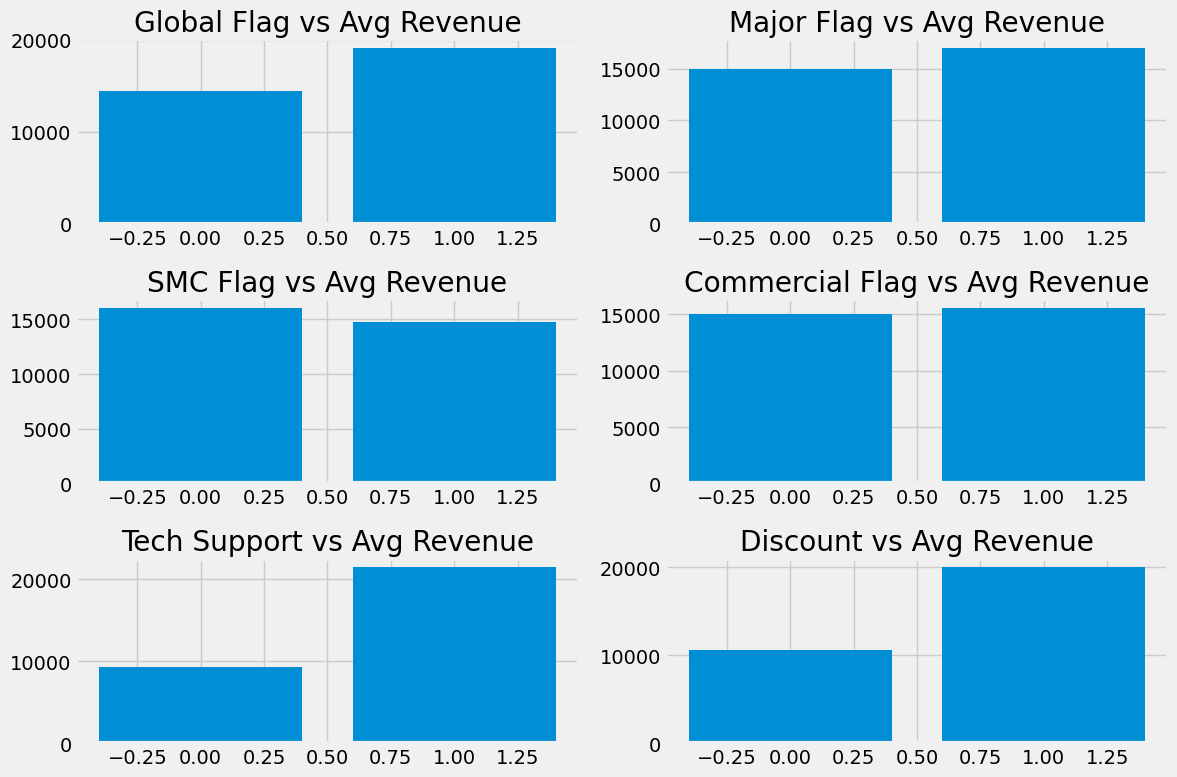

In [309]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'df' is your DataFrame containing the data
# Convert flags to categorical data for easier plotting
df['Global Flag'] = df['Global Flag'].astype('category')
df['Major Flag'] = df['Major Flag'].astype('category')
df['SMC Flag'] = df['SMC Flag'].astype('category')
df['Commercial Flag'] = df['Commercial Flag'].astype('category')
df['Tech Support'] = df['Tech Support'].astype('category')
df['Discount'] = df['Discount'].astype('category')

# Calculate average revenue for each flag category
avg_revenue_global = df.groupby('Global Flag')['Revenue'].mean()
avg_revenue_major = df.groupby('Major Flag')['Revenue'].mean()
avg_revenue_smc = df.groupby('SMC Flag')['Revenue'].mean()
avg_revenue_commercial = df.groupby('Commercial Flag')['Revenue'].mean()
avg_revenue_discount = df.groupby('Discount')['Revenue'].mean()
avg_revenue_tech = df.groupby('Tech Support')['Revenue'].mean()

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

# Plot for Global Flag
axs[0, 0].bar(avg_revenue_global.index, avg_revenue_global.values)
axs[0, 0].set_title('Global Flag vs Avg Revenue')

# Plot for Major Flag
axs[0, 1].bar(avg_revenue_major.index, avg_revenue_major.values)
axs[0, 1].set_title('Major Flag vs Avg Revenue')

# Plot for SMC Flag
axs[1, 0].bar(avg_revenue_smc.index, avg_revenue_smc.values)
axs[1, 0].set_title('SMC Flag vs Avg Revenue')

# Plot for Commercial Flag
axs[1, 1].bar(avg_revenue_commercial.index, avg_revenue_commercial.values)
axs[1, 1].set_title('Commercial Flag vs Avg Revenue')

axs[2, 0].bar(avg_revenue_tech.index, avg_revenue_tech.values)
axs[2, 0].set_title('Tech Support vs Avg Revenue')

axs[2, 1].bar(avg_revenue_discount.index, avg_revenue_discount.values)
axs[2, 1].set_title('Discount vs Avg Revenue')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


** insight **
- From this plot, show that if a client is global, major, not small & median size, is a commercial company. It will generate more revenue compare to others.
- If we provide a tech support and discount to the company, we tend to get more revenue.
- However the cause on whether the company type and size matter or tech support and Discount campign matter cannot be understand from these plots. We need to analyze further.

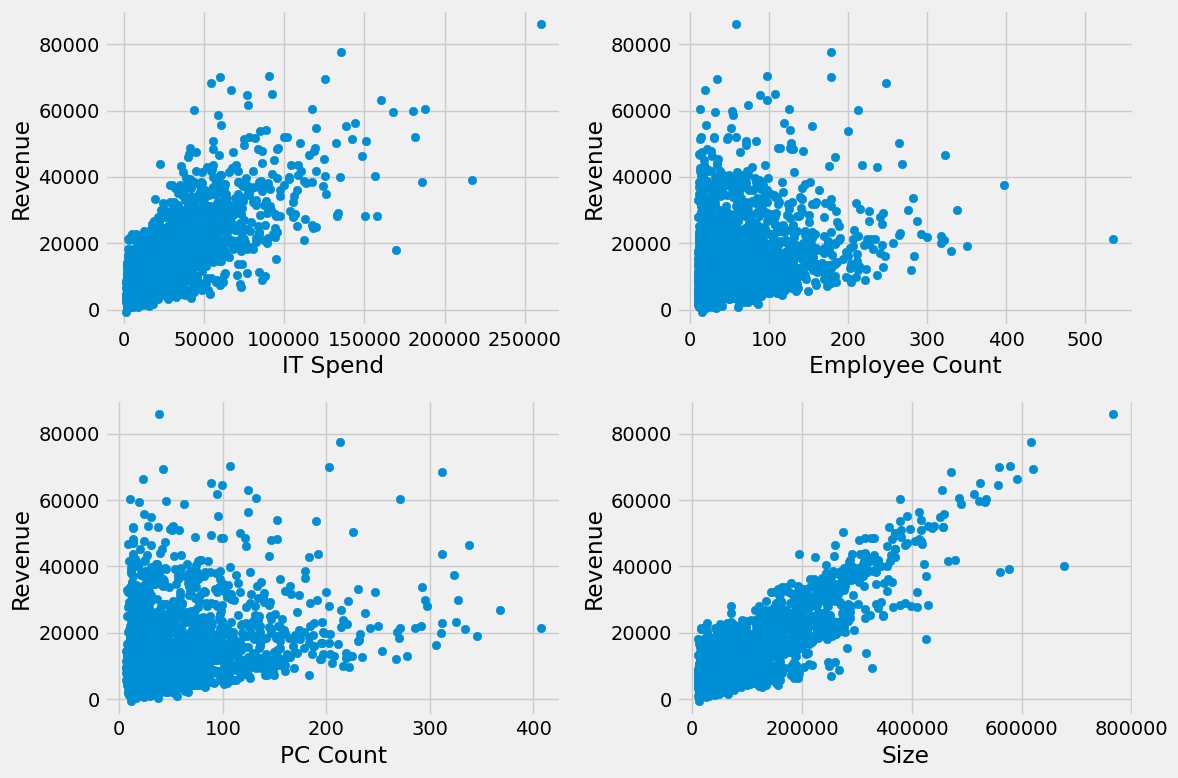

In [310]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Scatter plot for IT Spend vs Revenue
axs[0, 0].scatter(df['IT Spend'], df['Revenue'])
axs[0, 0].set_xlabel('IT Spend')
axs[0, 0].set_ylabel('Revenue')

# Scatter plot for Employee Count vs Revenue
axs[0, 1].scatter(df['Employee Count'], df['Revenue'])
axs[0, 1].set_xlabel('Employee Count')
axs[0, 1].set_ylabel('Revenue')

# Scatter plot for PC Count vs Revenue
axs[1, 0].scatter(df['PC Count'], df['Revenue'])
axs[1, 0].set_xlabel('PC Count')
axs[1, 0].set_ylabel('Revenue')

# Scatter plot for Size vs Revenue
axs[1, 1].scatter(df['Size'], df['Revenue'])
axs[1, 1].set_xlabel('Size')
axs[1, 1].set_ylabel('Revenue')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


** sights **
- All client IT spending, employee count, PC Count, Size have a positive correlation to our revenue.

In [311]:
for i in df.columns[4:8]:
  df[i] = df[i].astype('int')



In [312]:
df.dtypes

Global Flag        category
Major Flag         category
SMC Flag           category
Commercial Flag    category
IT Spend              int64
Employee Count        int64
PC Count              int64
Size                  int64
Tech Support       category
Discount           category
Revenue             float64
dtype: object

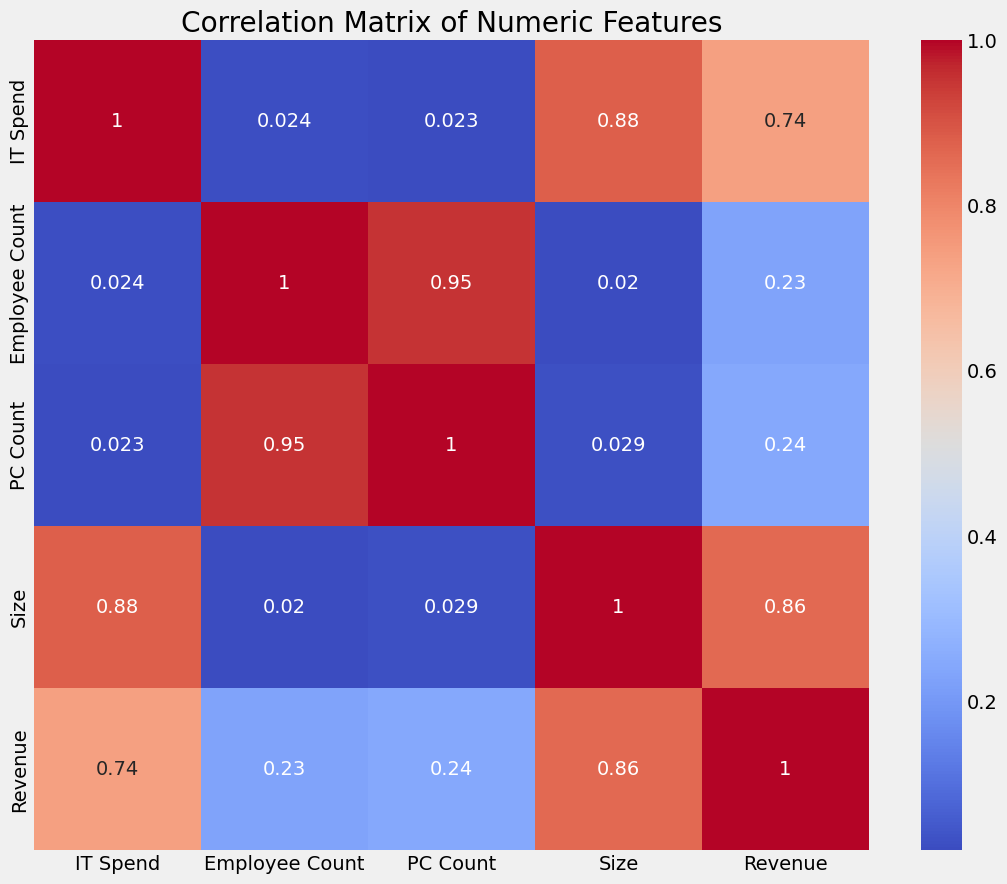

In [313]:
import seaborn as sns
# Select only numeric columns for correlation calculation
numeric_cols = df.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

## Standardize the dataset

In [314]:
df1 = df

In [315]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns for scaling
numerical_columns = ['IT Spend', 'Employee Count', 'PC Count', 'Size']

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the numerical columns
df1[numerical_columns] = scaler.fit_transform(df1[numerical_columns])

# Check the first few rows of the scaled DataFrame


from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for col in ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'Tech Support', 'Discount']:
    df1[col] = label_encoder.fit_transform(df1[col])

# Check the first few rows of the DataFrame after encoding

print(df1.head())

   Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0  0.612207   
1            0           0         1                1 -0.263499   
2            0           0         0                1  1.911281   
3            0           0         0                0  0.071464   
4            0           0         1                0 -0.083074   

   Employee Count  PC Count      Size  Tech Support  Discount      Revenue  
0       -0.657137 -0.593127  0.386737             0         1  17688.36300  
1        0.858685  0.239451  0.454416             0         1  14981.43559  
2       -0.956559 -0.952649  1.503292             1         1  32917.13894  
3       -0.395143 -0.347138 -0.352974             1         1  14773.76855  
4       -0.451285 -0.271449 -0.215062             1         1  17098.69823  


# Discount Testing

 ## LRSRegressor Testing

### Define Treatment, X, and Y

* Discount as Treatment for now, further test could be Tech Support


In [413]:
pd.Series(df['Discount']).value_counts(normalize=True)

1    0.5105
0    0.4895
Name: Discount, dtype: float64

In [414]:
pd.Series(df['Tech Support']).value_counts(normalize=True)

1    0.503
0    0.497
Name: Tech Support, dtype: float64

### Treatment Testing for Discount

In [415]:
y = df.Revenue
X = df.drop(columns=['Revenue', 'Discount'])
treatment = df['Discount']

print(X.head())


   Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0  0.612207   
1            0           0         1                1 -0.263499   
2            0           0         0                1  1.911281   
3            0           0         0                0  0.071464   
4            0           0         1                0 -0.083074   

   Employee Count  PC Count      Size  Tech Support  
0       -0.657137 -0.593127  0.386737             0  
1        0.858685  0.239451  0.454416             0  
2       -0.956559 -0.952649  1.503292             1  
3       -0.395143 -0.347138 -0.352974             1  
4       -0.451285 -0.271449 -0.215062             1  


In [416]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.tf import DragonNet
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset.regression import *
from causalml.metrics import *

In [417]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [418]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 10
[LightGBM] [Info] Start training from score 15397.917433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 10
[LightGBM] [Info] Start training from score 15397.917433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 780
[LightGBM] [Info] Number of data points in the train 

In [419]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 4s 35ms/step - loss: 46290755584.0000 - regression_loss: 23146002432.0000 - binary_classification_loss: 79.9790 - treatment_accuracy: 0.4681 - track_epsilon: 0.0312 - val_loss: 46204919808.0000 - val_regression_loss: 21031397376.0000 - val_binary_classification_loss: 176.9590 - val_treatment_accuracy: 0.5045 - val_track_epsilon: 0.0440 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 13ms/step - loss: 41460604928.0000 - regression_loss: 20733839360.0000 - binary_classification_loss: 216.9358 - treatment_accuracy: 0.4931 - track_epsilon: 0.0588 - val_loss: 29985896448.0000 - val_regression_loss: 13605018624.0000 - val_binary_classification_loss: 204.0253 - val_treatment_accuracy: 0.5000 - val_track_epsilon: 0.0746 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 15ms/step - loss: 10798002176.0000 - regression_loss: 5400370176.0000 - binary_classification_loss: 224.4885 - treatment_accuracy: 0.4894 

In [420]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [421]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate],
                     index=['S','T','X','R','dragonnet'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [422]:
df_result

ATE      AUUC
S          5423.762401  0.628688
T          5706.450534  0.639767
X          5555.791775  0.630690
R          5353.761173  0.618634
dragonnet          NaN  0.480331

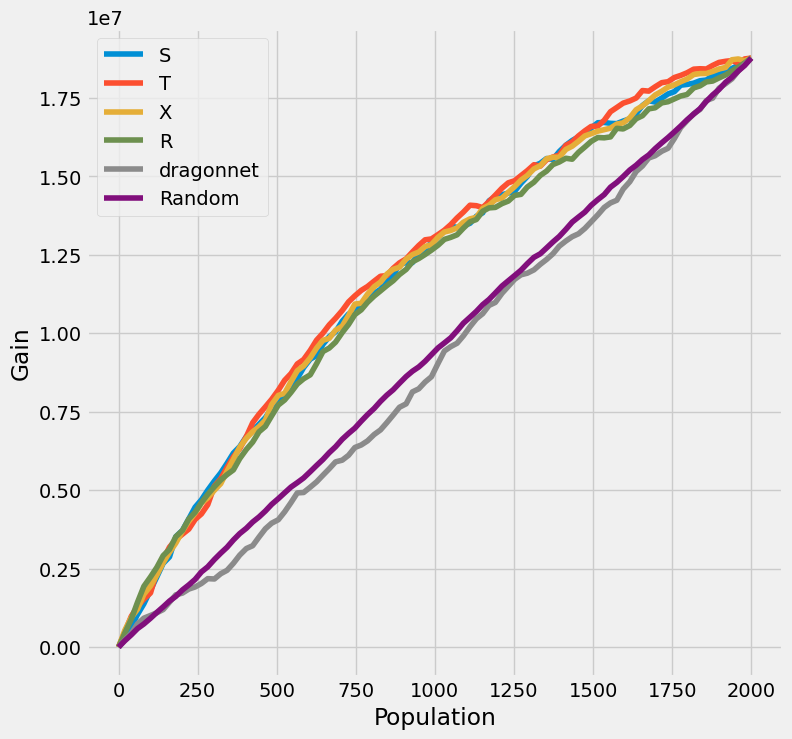

In [423]:
plot_gain(df_preds)

T seems to be better than other in term of "Discount"


### Treatment Testing for "Tech Support"

In [424]:
y = df.Revenue
X = df.drop(columns=['Revenue', 'Tech Support'])
treatment = df['Tech Support']

In [425]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [426]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 10
[LightGBM] [Info] Start training from score 15397.917433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 10
[LightGBM] [Info] Start training from score 15397.917433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [427]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 5s 44ms/step - loss: 46304612352.0000 - regression_loss: 23152547840.0000 - binary_classification_loss: 65.3138 - treatment_accuracy: 0.4837 - track_epsilon: 0.0218 - val_loss: 46258319360.0000 - val_regression_loss: 21055508480.0000 - val_binary_classification_loss: 137.2042 - val_treatment_accuracy: 0.5067 - val_track_epsilon: 0.0351 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 16ms/step - loss: 42133446656.0000 - regression_loss: 21069991936.0000 - binary_classification_loss: 212.2987 - treatment_accuracy: 0.4881 - track_epsilon: 0.0503 - val_loss: 32388208640.0000 - val_regression_loss: 14713836544.0000 - val_binary_classification_loss: 195.0614 - val_treatment_accuracy: 0.5045 - val_track_epsilon: 0.0675 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 16ms/step - loss: 12327924736.0000 - regression_loss: 6165639168.0000 - binary_classification_loss: 224.7676 - treatment_accuracy: 0.4881 

In [428]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [429]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate],
                     index=['S','T','X','R','dragonnet'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [430]:
df_result

ATE      AUUC
S          6905.988109  0.524557
T          7398.219187  0.551137
X          7182.520496  0.538264
R          7063.526312  0.507670
dragonnet          NaN  0.509656

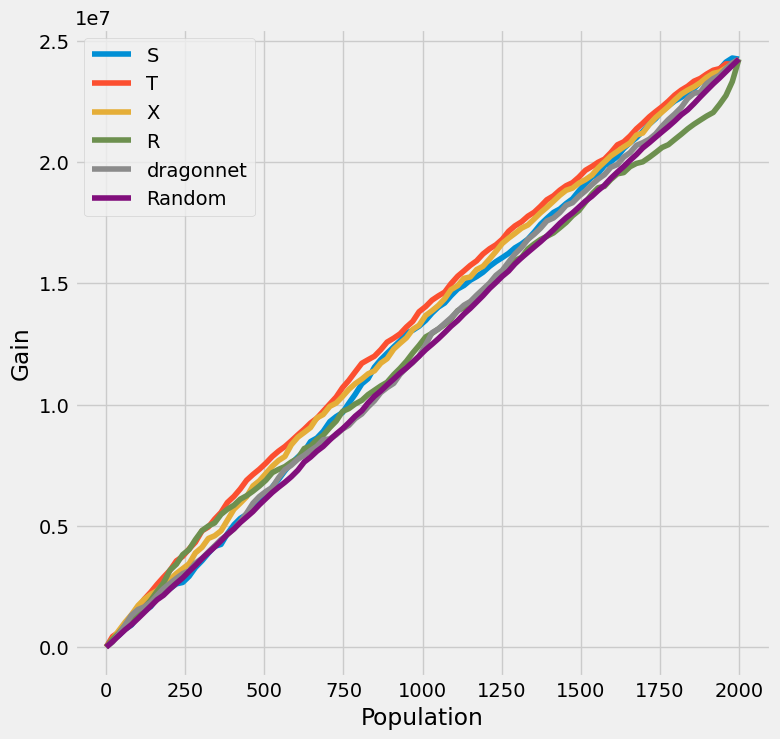

In [431]:
plot_gain(df_preds)

- In this case, T is also better than others.
- And compare these two graphs it shows Discount has more effect on revenue than Tech Support.
- Keep Discount as treatment.

## Feature Intrepretation

In [432]:
feature_names = []
feature_names = df.columns
feature_names

Index(['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend',
       'Employee Count', 'PC Count', 'Size', 'Tech Support', 'Discount',
       'Revenue'],
      dtype='object')

In [433]:
feature_names = [name for name in feature_names if name not in ['Revenue', 'Discount']]
model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

In [434]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Size               0.905045
 PC Count           0.038498
 Employee Count     0.024863
 IT Spend           0.015813
 Tech Support       0.004446
 SMC Flag           0.003412
 Global Flag        0.003345
 Commercial Flag    0.002358
 Major Flag         0.002221
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

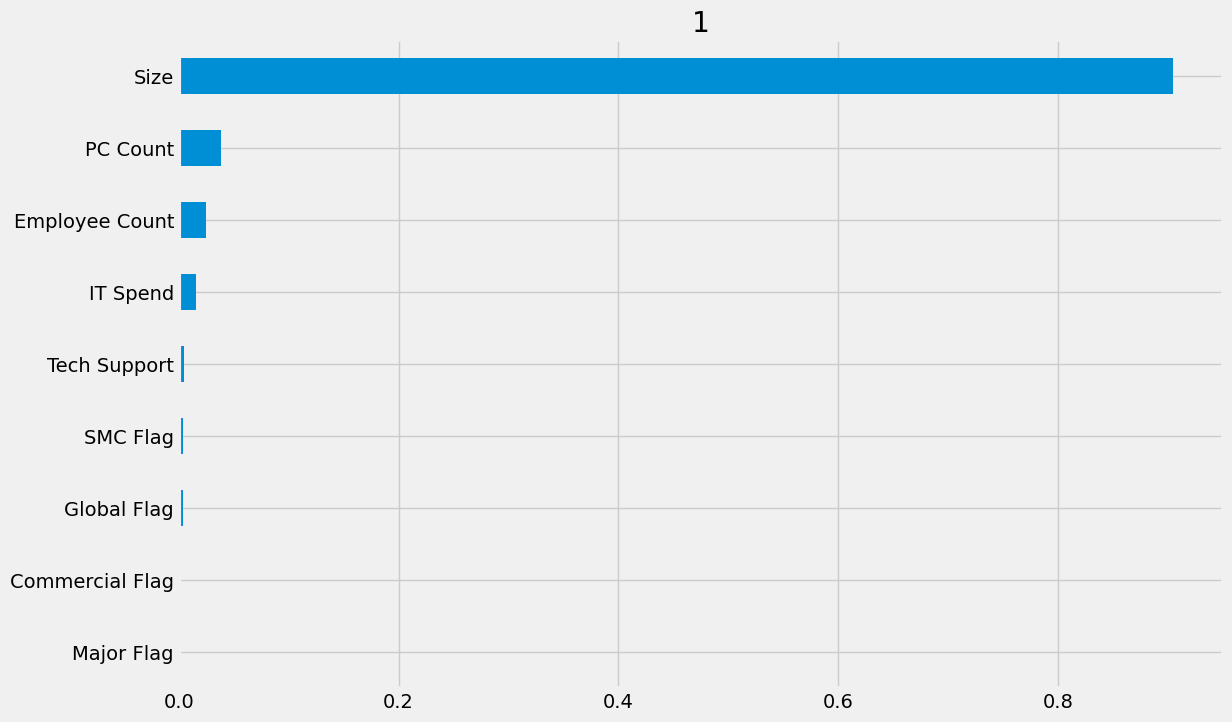

In [435]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names)

Size are really matter to our revenue

In [436]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        method='permutation',
                        features=feature_names,
                        random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Size               1.887604
 Employee Count     0.065625
 PC Count           0.054293
 IT Spend           0.037779
 Tech Support       0.006780
 Global Flag        0.004465
 Commercial Flag    0.003425
 Major Flag         0.002985
 SMC Flag           0.001056
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

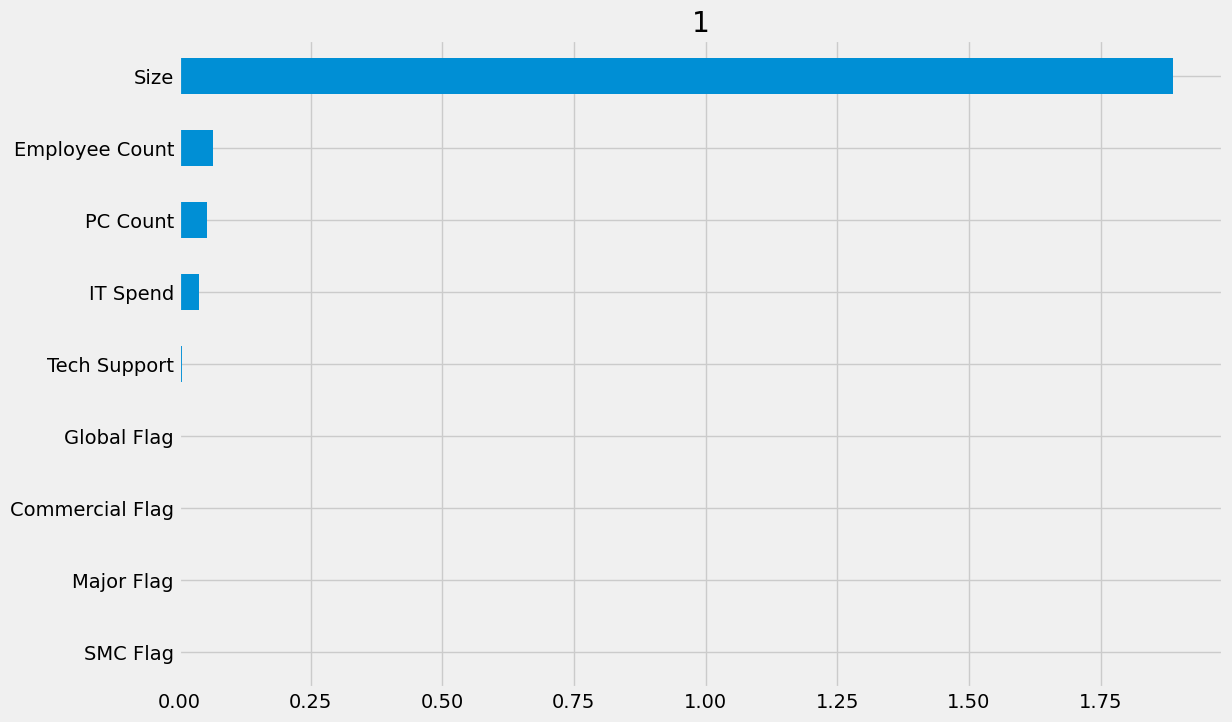

In [437]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         method='permutation',
                         features=feature_names,
                         random_state=42)

In [438]:
import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, t_ite, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 9
[LightGBM] [Info] Start training from score 7407.203565
Elapsed time: 0.48354268074035645 seconds


In [439]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Size               1.887604
Employee Count     0.065625
PC Count           0.054293
IT Spend           0.037779
Tech Support       0.006780
Global Flag        0.004465
Commercial Flag    0.003425
Major Flag         0.002985
SMC Flag           0.001056
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

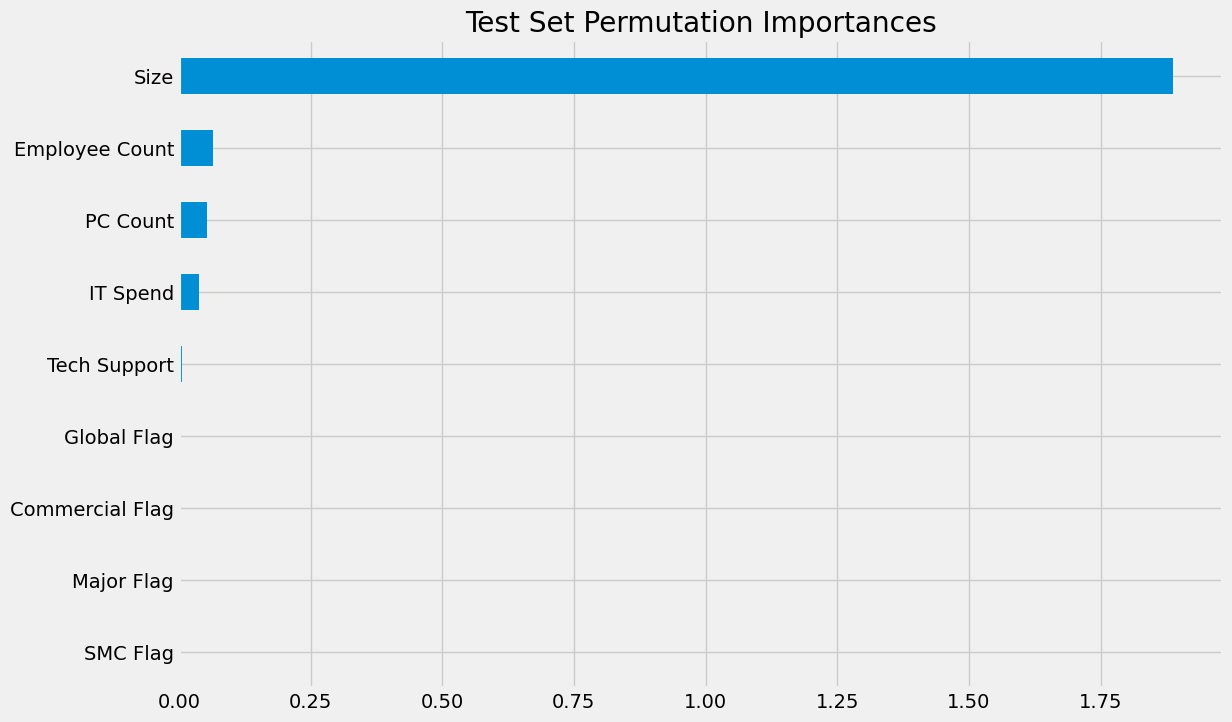

In [440]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [441]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 4.56707361e+02,  1.05543183e+01, -2.36460771e+01, ...,
         -1.73213907e+02,  9.09538212e+02,  1.44782467e+00],
        [-1.04317423e+02,  4.43698658e+01,  2.38929878e+01, ...,
         -8.91648363e-01,  1.09411352e+03,  1.11499996e+02],
        [-3.78774014e+01, -7.70653603e+01, -8.27740553e+01, ...,
         -4.54628494e+02,  2.78320460e+03, -5.11070389e+01],
        ...,
        [-1.43161716e+00,  9.65760944e+00,  1.64559474e+02, ...,
          6.59584852e+01, -1.81212409e+03, -2.21743574e+01],
        [ 2.08161662e+01,  1.22508788e+00,  3.69408116e+01, ...,
          2.39909179e+02, -1.49872973e+03, -8.80131305e+00],
        [-7.04668946e+01, -1.27589990e+02,  2.79103462e+01, ...,
         -9.90628736e+00,  6.82587037e+02, -2.47319217e+01]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

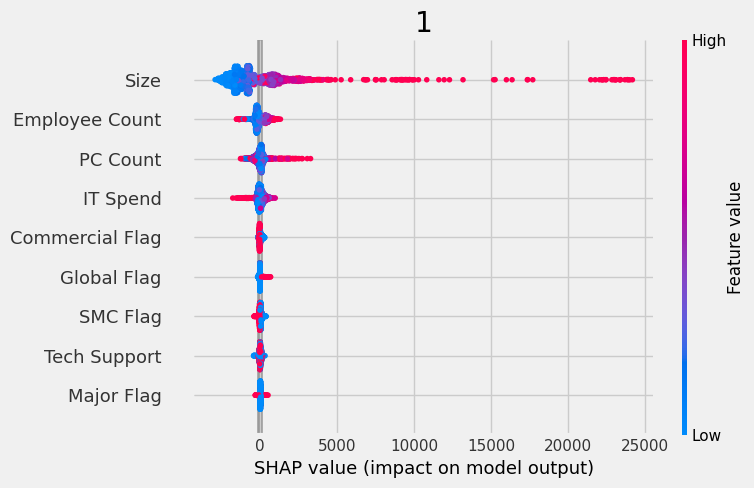

In [442]:
t_learner.plot_shap_values(X=X, tau=t_ite, features=feature_names)

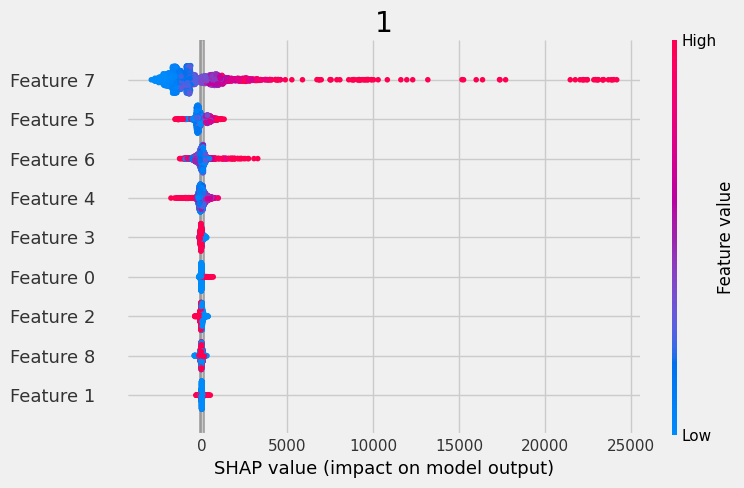

In [443]:
# Plot shap values WITH specifying shap_dict
t_learner.plot_shap_values(X=X, shap_dict=shap_tlearner)

## XGBRegressor Testing

In [444]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns for scaling
numerical_columns = ['IT Spend', 'Employee Count', 'PC Count', 'Size']

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the numerical columns
df1[numerical_columns] = scaler.fit_transform(df1[numerical_columns])

# Check the first few rows of the scaled DataFrame


from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for col in ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'Tech Support', 'Discount']:
    df1[col] = label_encoder.fit_transform(df1[col])

# Check the first few rows of the DataFrame after encoding

print(df1.head())

   Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0  0.171570   
1            0           0         1                1  0.076092   
2            0           0         0                1  0.313207   
3            0           0         0                0  0.112613   
4            0           0         1                0  0.095764   

   Employee Count  PC Count      Size  Tech Support  Discount      Revenue  
0        0.030476  0.049875  0.187873             0         1  17688.36300  
1        0.184762  0.159601  0.196907             0         1  14981.43559  
2        0.000000  0.002494  0.336911             1         1  32917.13894  
3        0.057143  0.082294  0.089136             1         1  14773.76855  
4        0.051429  0.092269  0.107545             1         1  17098.69823  


In [445]:
y = df.Revenue
X = df.drop(columns=['Revenue', 'Discount'])
treatment = df['Discount']

print(X.head())

   Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0  0.612207   
1            0           0         1                1 -0.263499   
2            0           0         0                1  1.911281   
3            0           0         0                0  0.071464   
4            0           0         1                0 -0.083074   

   Employee Count  PC Count      Size  Tech Support  
0       -0.657137 -0.593127  0.386737             0  
1        0.858685  0.239451  0.454416             0  
2       -0.956559 -0.952649  1.503292             1  
3       -0.395143 -0.347138 -0.352974             1  
4       -0.451285 -0.271449 -0.215062             1  


In [446]:
s_learner = BaseSRegressor(XGBRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(XGBRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(XGBRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(XGBRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

In [447]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [448]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 4s 30ms/step - loss: 46298288128.0000 - regression_loss: 23149301760.0000 - binary_classification_loss: 62.2068 - treatment_accuracy: 0.4956 - track_epsilon: 0.0463 - val_loss: 46261682176.0000 - val_regression_loss: 21056579584.0000 - val_binary_classification_loss: 134.9393 - val_treatment_accuracy: 0.4911 - val_track_epsilon: 0.0489 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 42208157696.0000 - regression_loss: 21105991680.0000 - binary_classification_loss: 204.6165 - treatment_accuracy: 0.5081 - track_epsilon: 0.0638 - val_loss: 32789061632.0000 - val_regression_loss: 14899629056.0000 - val_binary_classification_loss: 189.0411 - val_treatment_accuracy: 0.4978 - val_track_epsilon: 0.0806 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 12252751872.0000 - regression_loss: 6126724096.0000 - binary_classification_loss: 216.1733 - treatment_accuracy: 0.5088 - 

In [449]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate],
                     index=['S','T','X','R'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [450]:
df_result

ATE      AUUC
S  5513.443887  0.636923
T  5780.499636  0.653192
X  5633.278446  0.636680
R  5843.590574  0.640876

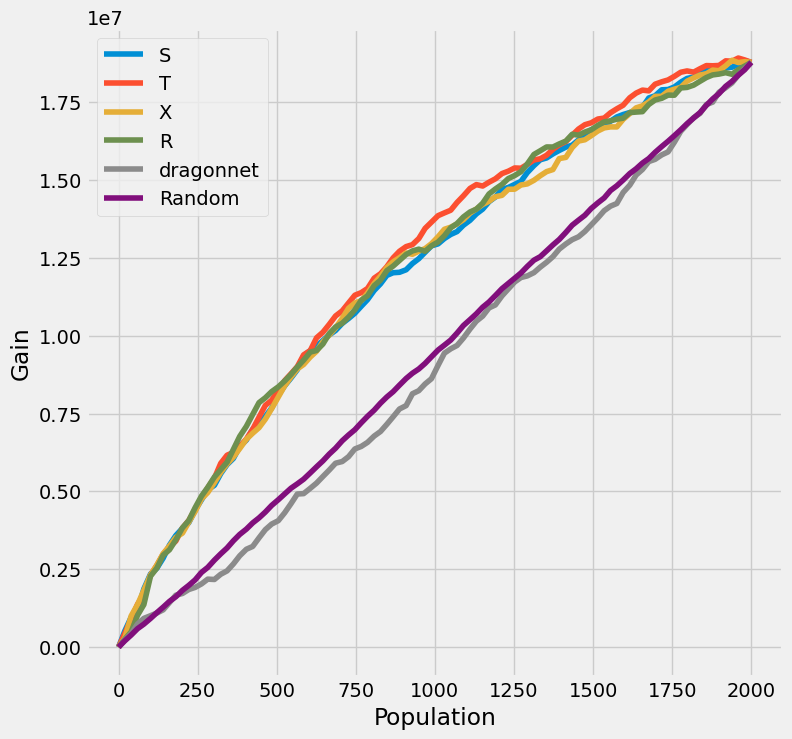

In [451]:
plot_gain(df_preds)

Treatment T has the highest ATE (5780.499636) among the options, indicating potentially the largest treatment effect.

Treatment S and Treatment X have slightly lower ATEs compared to T, but they have slightly lower AUUC values. This suggests that the estimates for these treatments might be more reliable or have less uncertainty compared to Treatment T.

Treatment R has the highest ATE among all treatments but has a slightly higher AUUC compared to Treatment S and Treatment X.

In [452]:
model_tau = XGBRegressor(importance_type='gain')  # specify model for model_tau

In [453]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Size               0.954122
 Employee Count     0.014090
 PC Count           0.012110
 IT Spend           0.007810
 Global Flag        0.003807
 SMC Flag           0.002917
 Tech Support       0.002291
 Commercial Flag    0.001849
 Major Flag         0.001002
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

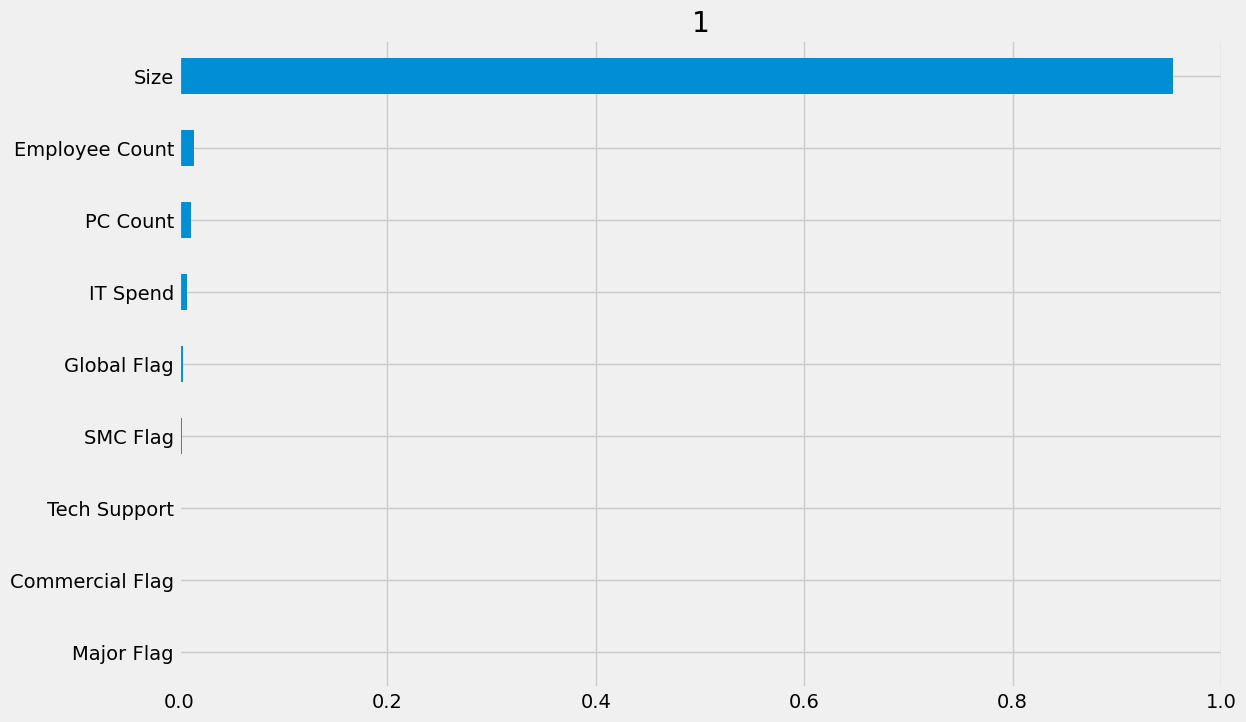

In [454]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names)

In [455]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[-1.32993366e+01,  6.54824360e+01, -6.87695406e+01, ...,
         -1.30355153e+02,  1.72031254e+03,  1.12513678e+02],
        [-3.27120435e+01,  2.32584675e+01, -2.46709835e+02, ...,
          6.20143977e+00,  1.67246878e+03, -5.23116614e+01],
        [-1.67902878e+02,  4.79297508e+01,  1.44628031e+02, ...,
          1.79574395e+01,  7.54454227e+03, -2.00267040e+02],
        ...,
        [-9.70458588e+00, -1.03602493e+01,  1.78119268e+02, ...,
          1.91883363e+01, -4.25973372e+03,  5.64082605e+01],
        [ 2.79804943e+01,  3.73143617e+01,  1.69754234e+02, ...,
          6.43556718e+01, -3.47961285e+03, -8.85194615e+01],
        [ 2.07603807e+01, -2.15678401e+02,  1.14663766e+02, ...,
         -7.29124925e+01,  1.56826918e+03,  4.21947250e+01]])}

In [456]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, t_ite, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.38335394859313965 seconds


In [457]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[-1.32993366e+01,  6.54824360e+01, -6.87695406e+01, ...,
         -1.30355153e+02,  1.72031254e+03,  1.12513678e+02],
        [-3.27120435e+01,  2.32584675e+01, -2.46709835e+02, ...,
          6.20143977e+00,  1.67246878e+03, -5.23116614e+01],
        [-1.67902878e+02,  4.79297508e+01,  1.44628031e+02, ...,
          1.79574395e+01,  7.54454227e+03, -2.00267040e+02],
        ...,
        [-9.70458588e+00, -1.03602493e+01,  1.78119268e+02, ...,
          1.91883363e+01, -4.25973372e+03,  5.64082605e+01],
        [ 2.79804943e+01,  3.73143617e+01,  1.69754234e+02, ...,
          6.43556718e+01, -3.47961285e+03, -8.85194615e+01],
        [ 2.07603807e+01, -2.15678401e+02,  1.14663766e+02, ...,
         -7.29124925e+01,  1.56826918e+03,  4.21947250e+01]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

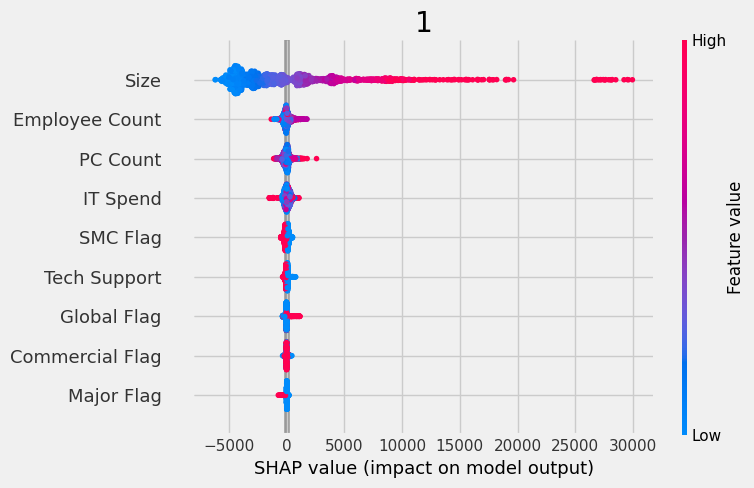

In [458]:
# Plot shap values without specifying shap_dict
t_learner.plot_shap_values(X=X, tau=t_ite, features=feature_names)

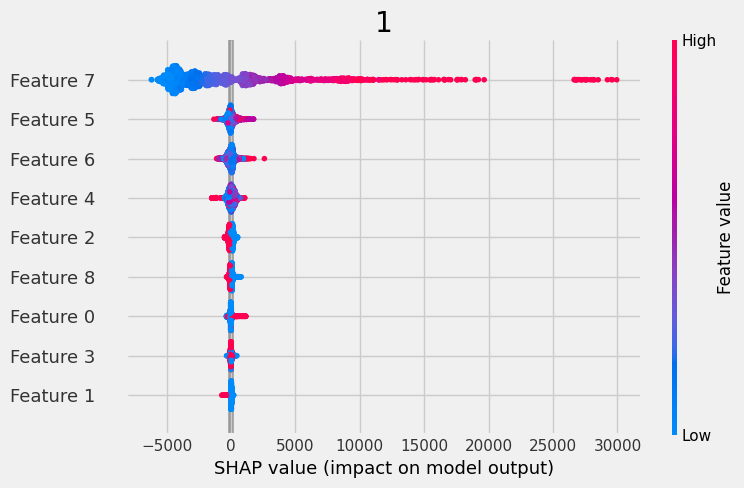

In [459]:
# Plot shap values WITH specifying shap_dict
t_learner.plot_shap_values(X=X, shap_dict=shap_tlearner)

# Tech Support Testing

In [391]:
# Tech support

In [392]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns for scaling
numerical_columns = ['IT Spend', 'Employee Count', 'PC Count', 'Size']

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the numerical columns
df1[numerical_columns] = scaler.fit_transform(df1[numerical_columns])

# Check the first few rows of the scaled DataFrame


from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for col in ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'Tech Support', 'Discount']:
    df1[col] = label_encoder.fit_transform(df1[col])

# Check the first few rows of the DataFrame after encoding

print(df1.head())


   Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0  0.171570   
1            0           0         1                1  0.076092   
2            0           0         0                1  0.313207   
3            0           0         0                0  0.112613   
4            0           0         1                0  0.095764   

   Employee Count  PC Count      Size  Tech Support  Discount      Revenue  
0        0.030476  0.049875  0.187873             0         1  17688.36300  
1        0.184762  0.159601  0.196907             0         1  14981.43559  
2        0.000000  0.002494  0.336911             1         1  32917.13894  
3        0.057143  0.082294  0.089136             1         1  14773.76855  
4        0.051429  0.092269  0.107545             1         1  17098.69823  


In [393]:
y = df.Revenue
X = df.drop(columns=['Revenue', 'Tech Support'])
treatment = df['Tech Support']

In [394]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [395]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 10
[LightGBM] [Info] Start training from score 15397.917433
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 10
[LightGBM] [Info] Start training from score 15397.917433
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train 

In [396]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 4s 30ms/step - loss: 46305529856.0000 - regression_loss: 23152795648.0000 - binary_classification_loss: 65.2573 - treatment_accuracy: 0.5063 - track_epsilon: 0.0118 - val_loss: 46270726144.0000 - val_regression_loss: 21059940352.0000 - val_binary_classification_loss: 146.0220 - val_treatment_accuracy: 0.4888 - val_track_epsilon: 0.0131 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 42065973248.0000 - regression_loss: 21033684992.0000 - binary_classification_loss: 203.6768 - treatment_accuracy: 0.5113 - track_epsilon: 0.0279 - val_loss: 32204464128.0000 - val_regression_loss: 14632344576.0000 - val_binary_classification_loss: 195.0597 - val_treatment_accuracy: 0.4955 - val_track_epsilon: 0.0442 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 10ms/step - loss: 13026393088.0000 - regression_loss: 6513167360.0000 - binary_classification_loss: 214.2287 - treatment_accuracy: 0.5131 -

In [397]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [398]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate],
                     index=['S','T','X','R','dragonnet'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [399]:
df_result

ATE      AUUC
S          6905.988109  0.524557
T          7398.219187  0.551137
X          7182.520496  0.538264
R          7187.014483  0.528357
dragonnet          NaN  0.509656

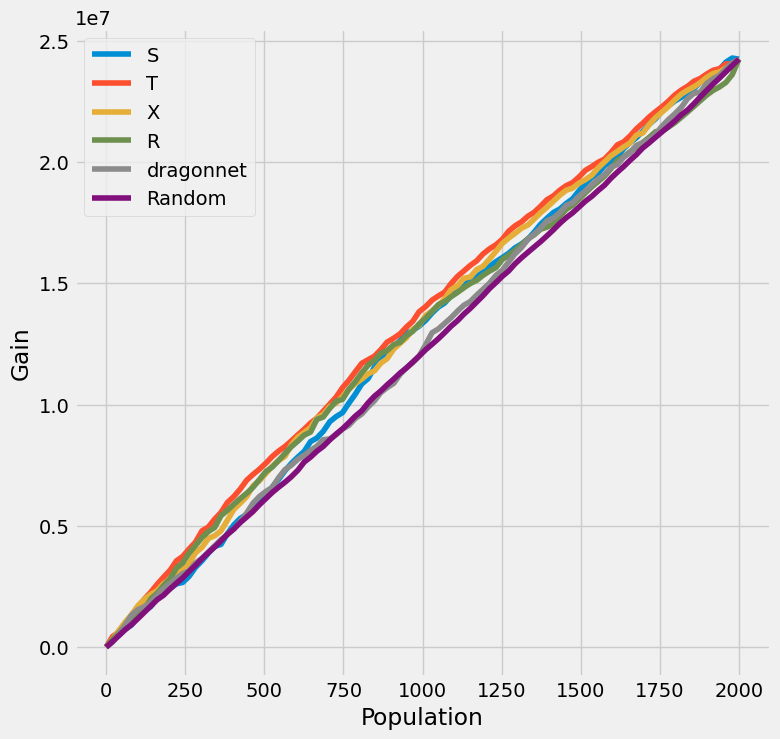

In [400]:
plot_gain(df_preds)

Use T Test

## Feature Intrepreation - LRS regression

In [401]:
feature_names = []
feature_names = df.columns
feature_names

Index(['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend',
       'Employee Count', 'PC Count', 'Size', 'Tech Support', 'Discount',
       'Revenue'],
      dtype='object')

In [402]:
feature_names = [name for name in feature_names if name not in ['Revenue', 'Tech Support']]
model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

In [403]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Size               0.905045
 PC Count           0.038498
 Employee Count     0.024863
 IT Spend           0.015813
 Discount           0.004446
 SMC Flag           0.003412
 Global Flag        0.003345
 Commercial Flag    0.002358
 Major Flag         0.002221
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

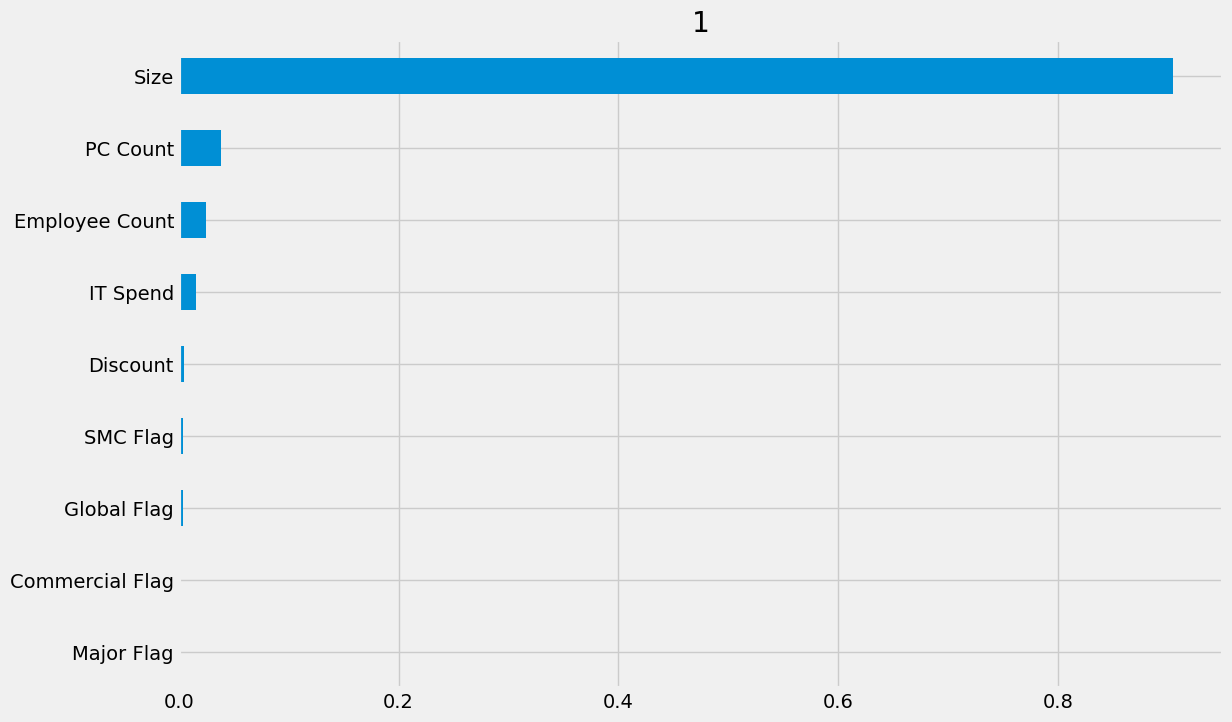

In [404]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names)

Size are really matter to our revenue

In [405]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        method='permutation',
                        features=feature_names,
                        random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Size               1.887604
 Employee Count     0.065625
 PC Count           0.054293
 IT Spend           0.037779
 Discount           0.006780
 Global Flag        0.004465
 Commercial Flag    0.003425
 Major Flag         0.002985
 SMC Flag           0.001056
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

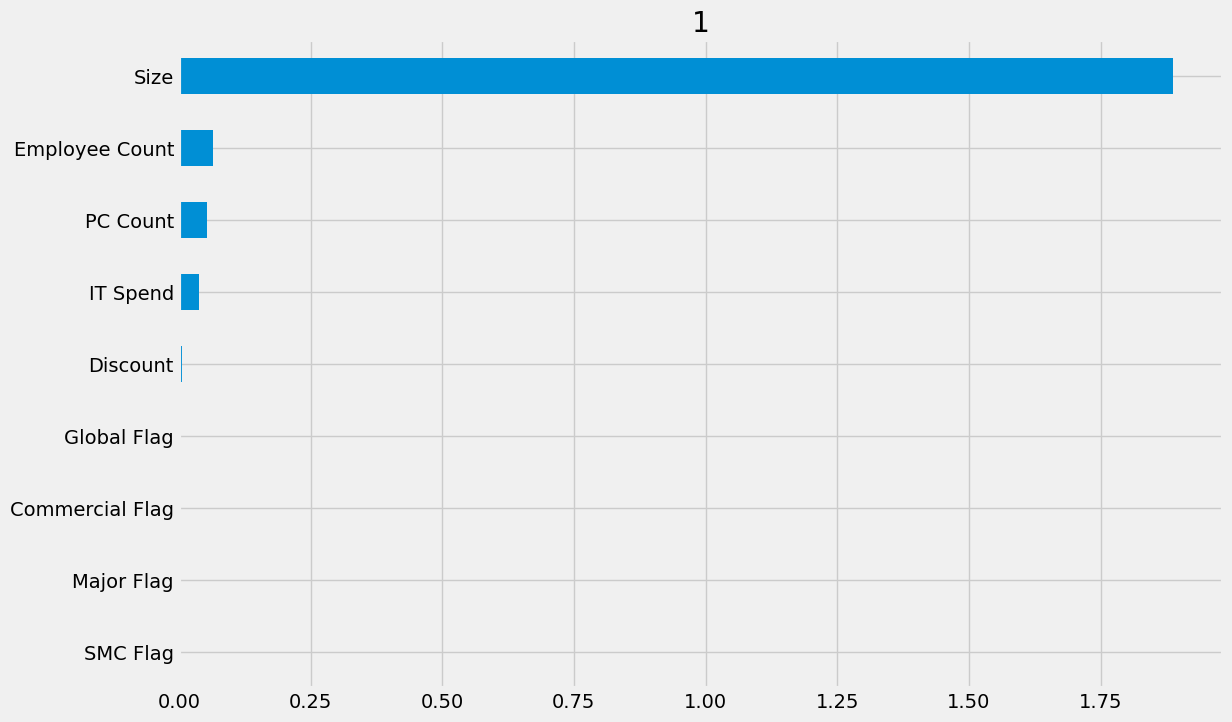

In [406]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         method='permutation',
                         features=feature_names,
                         random_state=42)

In [407]:
import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, t_ite, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 9
[LightGBM] [Info] Start training from score 7407.203565
Elapsed time: 0.49642062187194824 seconds


In [408]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Size               1.887604
Employee Count     0.065625
PC Count           0.054293
IT Spend           0.037779
Discount           0.006780
Global Flag        0.004465
Commercial Flag    0.003425
Major Flag         0.002985
SMC Flag           0.001056
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

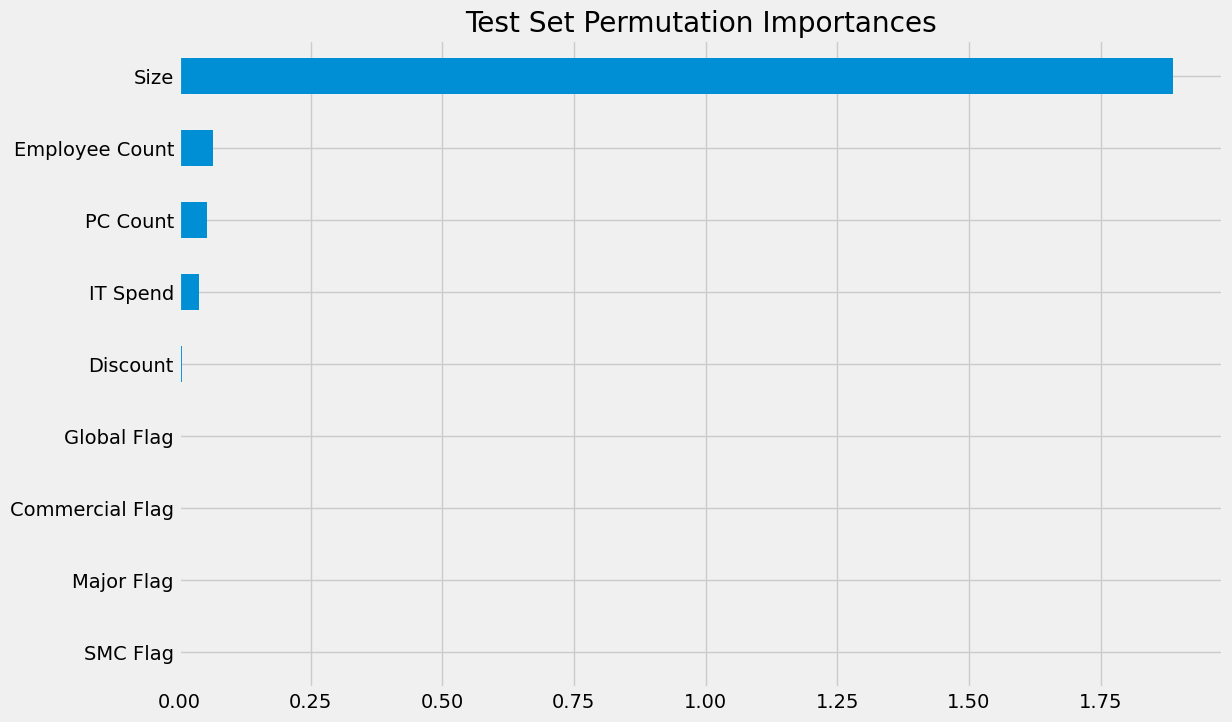

In [409]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [410]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 4.56707361e+02,  1.05543183e+01, -2.36460771e+01, ...,
         -1.73213907e+02,  9.09538212e+02,  1.44782467e+00],
        [-1.04317423e+02,  4.43698658e+01,  2.38929878e+01, ...,
         -8.91648363e-01,  1.09411352e+03,  1.11499996e+02],
        [-3.78774014e+01, -7.70653603e+01, -8.27740553e+01, ...,
         -4.54628494e+02,  2.78320460e+03, -5.11070389e+01],
        ...,
        [-1.43161716e+00,  9.65760944e+00,  1.64559474e+02, ...,
          6.59584852e+01, -1.81212409e+03, -2.21743574e+01],
        [ 2.08161662e+01,  1.22508788e+00,  3.69408116e+01, ...,
          2.39909179e+02, -1.49872973e+03, -8.80131305e+00],
        [-7.04668946e+01, -1.27589990e+02,  2.79103462e+01, ...,
         -9.90628736e+00,  6.82587037e+02, -2.47319217e+01]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

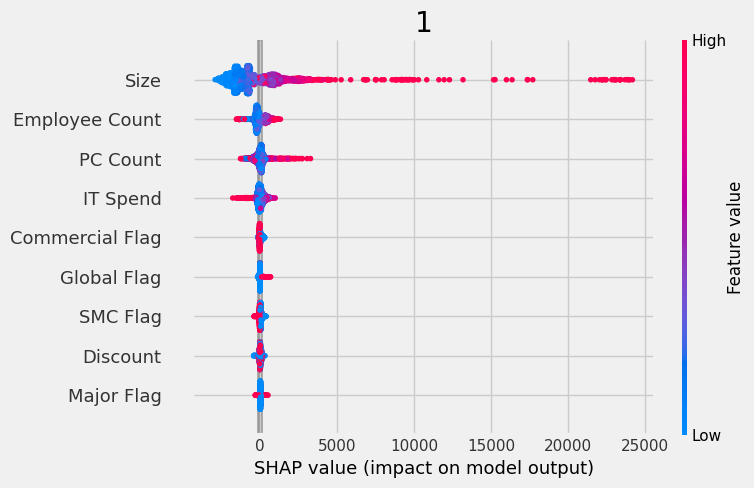

In [411]:
t_learner.plot_shap_values(X=X, tau=t_ite, features=feature_names)

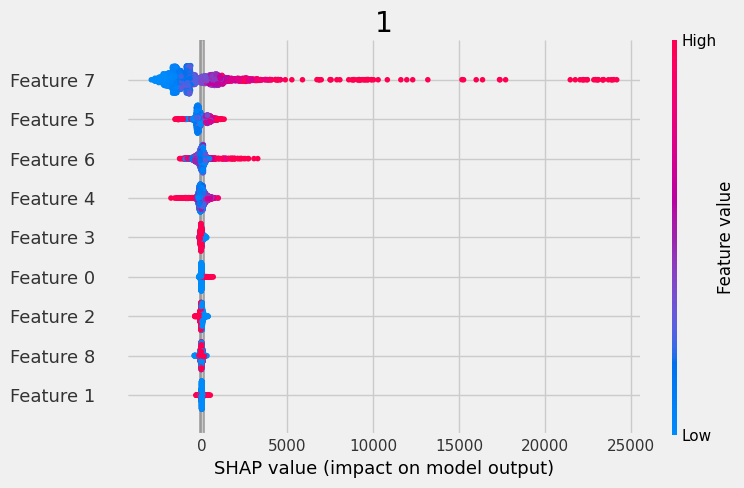

In [412]:
# Plot shap values WITH specifying shap_dict
t_learner.plot_shap_values(X=X, shap_dict=shap_tlearner)

## XGB Testing

In [461]:
y = df.Revenue
X = df.drop(columns=['Revenue', 'Tech Support'])
treatment = df['Tech Support']

print(X.head())

   Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0  0.612207   
1            0           0         1                1 -0.263499   
2            0           0         0                1  1.911281   
3            0           0         0                0  0.071464   
4            0           0         1                0 -0.083074   

   Employee Count  PC Count      Size  Discount  
0       -0.657137 -0.593127  0.386737         1  
1        0.858685  0.239451  0.454416         1  
2       -0.956559 -0.952649  1.503292         1  
3       -0.395143 -0.347138 -0.352974         1  
4       -0.451285 -0.271449 -0.215062         1  


In [462]:
s_learner = BaseSRegressor(XGBRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(XGBRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(XGBRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(XGBRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

In [463]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [464]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 7s 33ms/step - loss: 46302330880.0000 - regression_loss: 23151577088.0000 - binary_classification_loss: 77.0273 - treatment_accuracy: 0.5156 - track_epsilon: 0.0685 - val_loss: 46255423488.0000 - val_regression_loss: 21054050304.0000 - val_binary_classification_loss: 166.2310 - val_treatment_accuracy: 0.4955 - val_track_epsilon: 0.0722 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 12ms/step - loss: 42323288064.0000 - regression_loss: 21163790336.0000 - binary_classification_loss: 206.1331 - treatment_accuracy: 0.5094 - track_epsilon: 0.0869 - val_loss: 32332075008.0000 - val_regression_loss: 14673856512.0000 - val_binary_classification_loss: 195.1958 - val_treatment_accuracy: 0.4933 - val_track_epsilon: 0.1027 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 10ms/step - loss: 12735819776.0000 - regression_loss: 6367558144.0000 - binary_classification_loss: 214.4057 - treatment_accuracy: 0.5113 

In [465]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate],
                     index=['S','T','X','R'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [466]:
df_result

ATE      AUUC
S  7001.401356  0.547979
T  7431.433633  0.581158
X  7199.921252  0.550233
R  7273.954569  0.547918

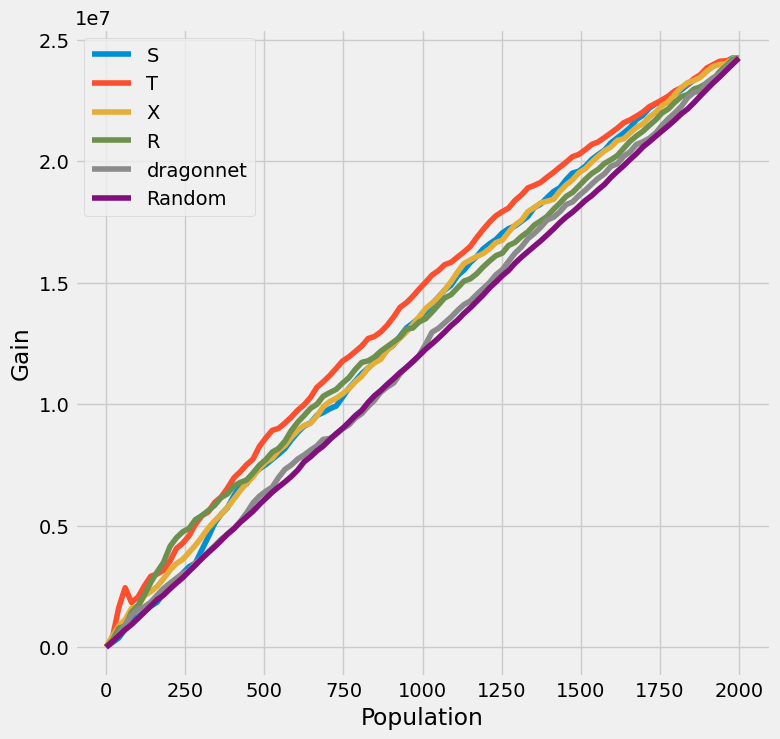

In [467]:
plot_gain(df_preds)

In [468]:
model_tau = XGBRegressor(importance_type='gain')  # specify model for model_tau

In [469]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Size               0.828217
 Employee Count     0.056729
 IT Spend           0.045081
 PC Count           0.041435
 Global Flag        0.011329
 Major Flag         0.005064
 Tech Support       0.005042
 Commercial Flag    0.004141
 SMC Flag           0.002963
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

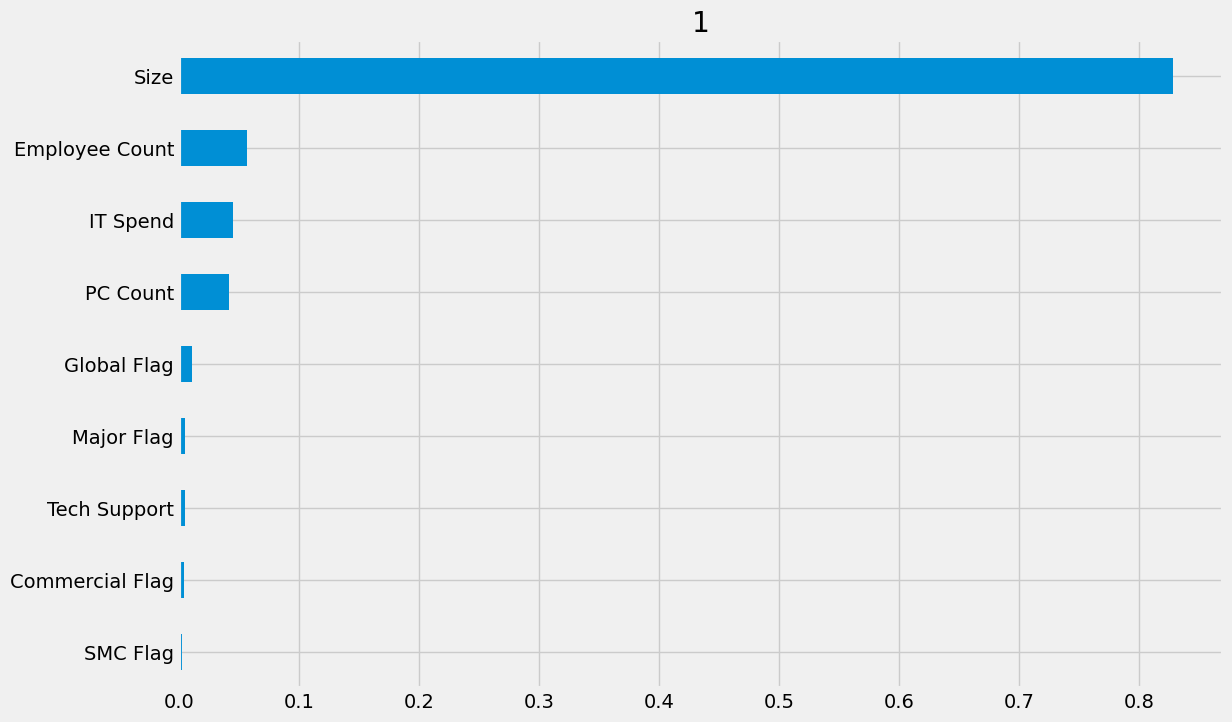

In [470]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names)

In [471]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 3.57886359e+02, -7.10614809e+00, -1.66116879e+01, ...,
         -1.98744968e+02,  1.00832476e+03,  8.37556853e+00],
        [-1.02949869e+02,  5.03873864e+01,  3.91741793e+01, ...,
         -4.28329858e+01,  1.42487833e+03,  1.83315780e+01],
        [-6.40483472e+01,  6.29124681e+01,  6.38587790e+00, ...,
          1.91786818e+02,  2.73967489e+03, -2.81317193e+01],
        ...,
        [ 2.15875703e+00,  1.26037120e+02,  1.22747445e+02, ...,
          1.90063933e+02, -1.91184980e+03, -3.26770667e+01],
        [-4.01940744e+00,  3.63067798e+00,  1.45349518e+01, ...,
          2.69962741e+02, -1.45825380e+03, -3.48449339e+01],
        [-7.02194977e+01, -2.50657901e+02,  2.15521518e+01, ...,
          5.81373280e+01,  9.04542312e+02, -1.01879398e+02]])}

In [472]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, t_ite, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.3870220184326172 seconds


In [473]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 3.57886359e+02, -7.10614809e+00, -1.66116879e+01, ...,
         -1.98744968e+02,  1.00832476e+03,  8.37556853e+00],
        [-1.02949869e+02,  5.03873864e+01,  3.91741793e+01, ...,
         -4.28329858e+01,  1.42487833e+03,  1.83315780e+01],
        [-6.40483472e+01,  6.29124681e+01,  6.38587790e+00, ...,
          1.91786818e+02,  2.73967489e+03, -2.81317193e+01],
        ...,
        [ 2.15875703e+00,  1.26037120e+02,  1.22747445e+02, ...,
          1.90063933e+02, -1.91184980e+03, -3.26770667e+01],
        [-4.01940744e+00,  3.63067798e+00,  1.45349518e+01, ...,
          2.69962741e+02, -1.45825380e+03, -3.48449339e+01],
        [-7.02194977e+01, -2.50657901e+02,  2.15521518e+01, ...,
          5.81373280e+01,  9.04542312e+02, -1.01879398e+02]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

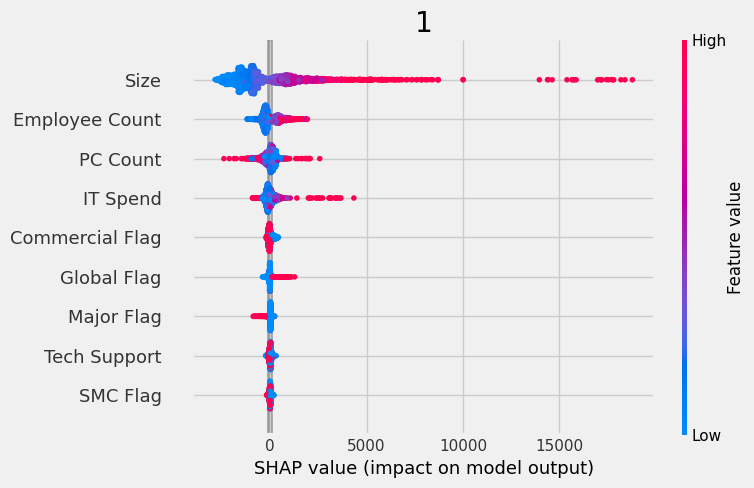

In [474]:
# Plot shap values without specifying shap_dict
t_learner.plot_shap_values(X=X, tau=t_ite, features=feature_names)

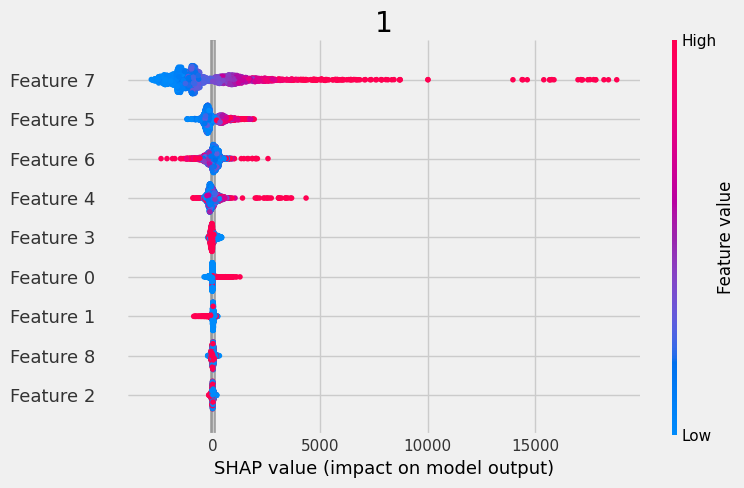

In [475]:
# Plot shap values WITH specifying shap_dict
t_learner.plot_shap_values(X=X, shap_dict=shap_tlearner)

# Conclusion find out customer size matters too much, then re-engineering the data


- more feature engineering needed
- more try to come up with a new feature that uses the ratio of revenue/customer size. => Discover the percentage on purchase of our product relate to its revenue

## New feature

### Data

In [505]:
df2 = pd.read_csv("multi_attribution_sample.csv")

In [506]:
df2.head()

Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0     45537   
1            0           0         1                1     20842   
2            0           0         0                1     82171   
3            0           0         0                0     30288   
4            0           0         1                0     25930   

   Employee Count  PC Count    Size  Tech Support  Discount      Revenue  
0              26        26  152205             0         1  17688.36300  
1             107        70  159038             0         1  14981.43559  
2              10         7  264935             1         1  32917.13894  
3              40        39   77522             1         1  14773.76855  
4              37        43   91446             1         1  17098.69823

In [507]:
df2['ratio'] = df2['Size'] / df2['Revenue']

In [508]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical columns for scaling
numerical_columns = ['IT Spend', 'Employee Count', 'PC Count', 'Size','Revenue',"ratio"]

# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform the numerical columns
df2[numerical_columns] = scaler.fit_transform(df2[numerical_columns])

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode categorical columns
for col in ['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'Tech Support', 'Discount']:
    df2[col] = label_encoder.fit_transform(df2[col])

# Check the first few rows of the DataFrame after encoding

print(df2.head())

   Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0  0.171570   
1            0           0         1                1  0.076092   
2            0           0         0                1  0.313207   
3            0           0         0                0  0.112613   
4            0           0         1                0  0.095764   

   Employee Count  PC Count      Size  Tech Support  Discount   Revenue  \
0        0.030476  0.049875  0.187873             0         1  0.211316   
1        0.184762  0.159601  0.196907             0         1  0.180067   
2        0.000000  0.002494  0.336911             1         1  0.387120   
3        0.057143  0.082294  0.089136             1         1  0.177669   
4        0.051429  0.092269  0.107545             1         1  0.204509   

      ratio  
0  0.455633  
1  0.489721  
2  0.446204  
3  0.398717  
4  0.400427  


In [509]:
df2 = df2.drop(columns=['Revenue', 'Size'])

## Discount

In [510]:
y = df2.ratio
X = df2.drop(columns=['ratio', 'Discount'])
treatment = df2['Discount']

print(X.head())

   Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0  0.171570   
1            0           0         1                1  0.076092   
2            0           0         0                1  0.313207   
3            0           0         0                0  0.112613   
4            0           0         1                0  0.095764   

   Employee Count  PC Count  Tech Support  
0        0.030476  0.049875             0  
1        0.184762  0.159601             0  
2        0.000000  0.002494             1  
3        0.057143  0.082294             1  
4        0.051429  0.092269             1  


### LRS Regression

In [511]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [512]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 9
[LightGBM] [Info] Start training from score 0.441442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 9
[LightGBM] [Info] Start training from score 0.441442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 979, 

In [513]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 5s 36ms/step - loss: 53.3458 - regression_loss: 2.2203 - binary_classification_loss: 44.2759 - treatment_accuracy: 0.5106 - track_epsilon: 0.0074 - val_loss: 48.9132 - val_regression_loss: 0.6758 - val_binary_classification_loss: 39.5635 - val_treatment_accuracy: 0.4933 - val_track_epsilon: 0.0047 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 10ms/step - loss: 49.1357 - regression_loss: 0.3302 - binary_classification_loss: 44.0393 - treatment_accuracy: 0.5312 - track_epsilon: 0.0042 - val_loss: 47.6133 - val_regression_loss: 0.2618 - val_binary_classification_loss: 39.3700 - val_treatment_accuracy: 0.5067 - val_track_epsilon: 0.0035 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 10ms/step - loss: 48.6518 - regression_loss: 0.2326 - binary_classification_loss: 43.9699 - treatment_accuracy: 0.5213 - track_epsilon: 0.0025 - val_loss: 47.1073 - val_regression_loss: 0.2809 - val_binary_classificat

In [514]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [515]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate],
                     index=['S','T','X','R','dragonnet'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [516]:
df_result

ATE      AUUC
S         -0.059916 -0.181270
T         -0.060289 -0.133517
X         -0.060576 -0.156131
R         -0.061053 -0.127095
dragonnet -0.061758 -0.230082

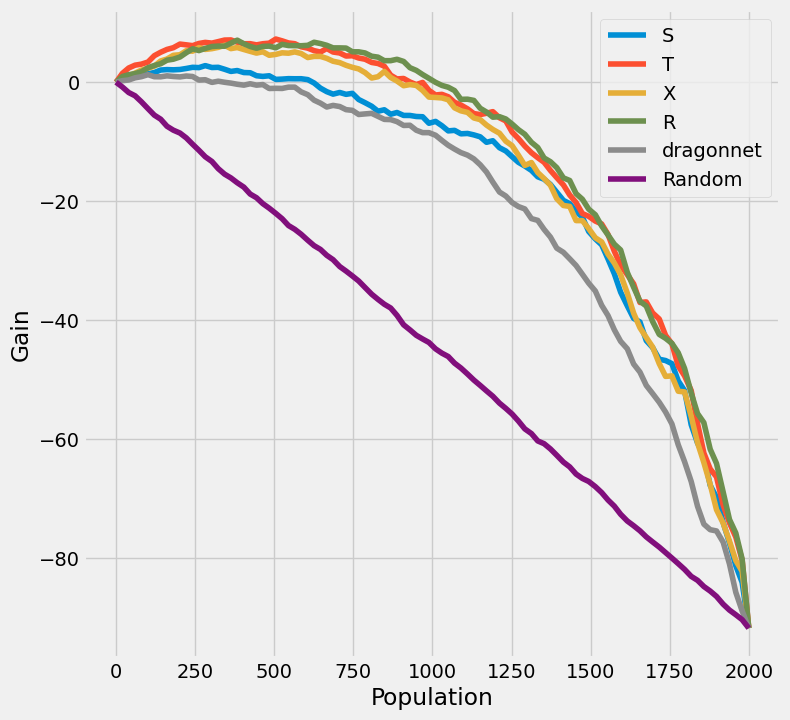

In [517]:
plot_gain(df_preds)

### Feature Intrepretation

In [518]:
feature_names = []
feature_names = df2.columns
feature_names

Index(['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend',
       'Employee Count', 'PC Count', 'Tech Support', 'Discount', 'ratio'],
      dtype='object')

In [519]:
feature_names = [name for name in feature_names if name not in ['ratio', 'Discount']]
model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

In [527]:
r_learner.get_importance(X=X,
                        tau=r_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: IT Spend           0.363097
 Employee Count     0.181839
 Tech Support       0.158555
 PC Count           0.149402
 Global Flag        0.075797
 Commercial Flag    0.035717
 Major Flag         0.019031
 SMC Flag           0.016563
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

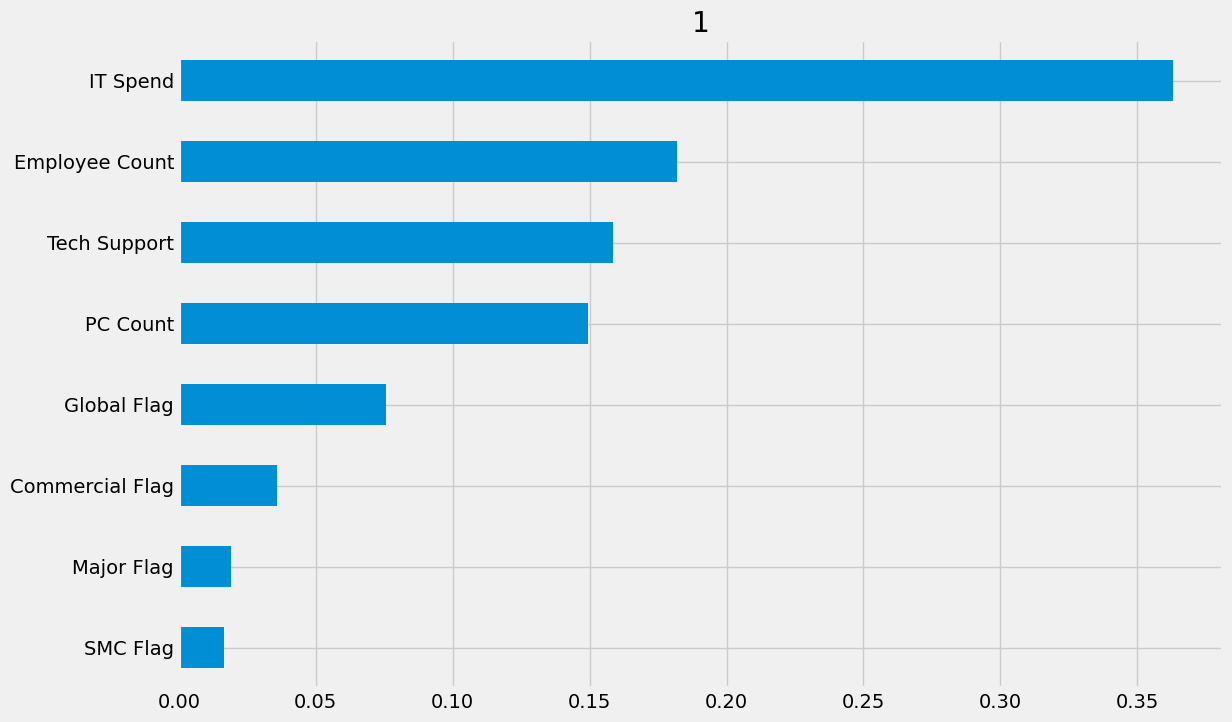

In [528]:
r_learner.plot_importance(X=X,
                         tau=r_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names)

In [529]:
r_learner.get_importance(X=X,
                        tau=r_ite,
                        method='permutation',
                        features=feature_names,
                        random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Tech Support       0.819520
 IT Spend           0.780099
 PC Count           0.296424
 Global Flag        0.189070
 Employee Count     0.143891
 Commercial Flag    0.060779
 Major Flag         0.057715
 SMC Flag           0.015940
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

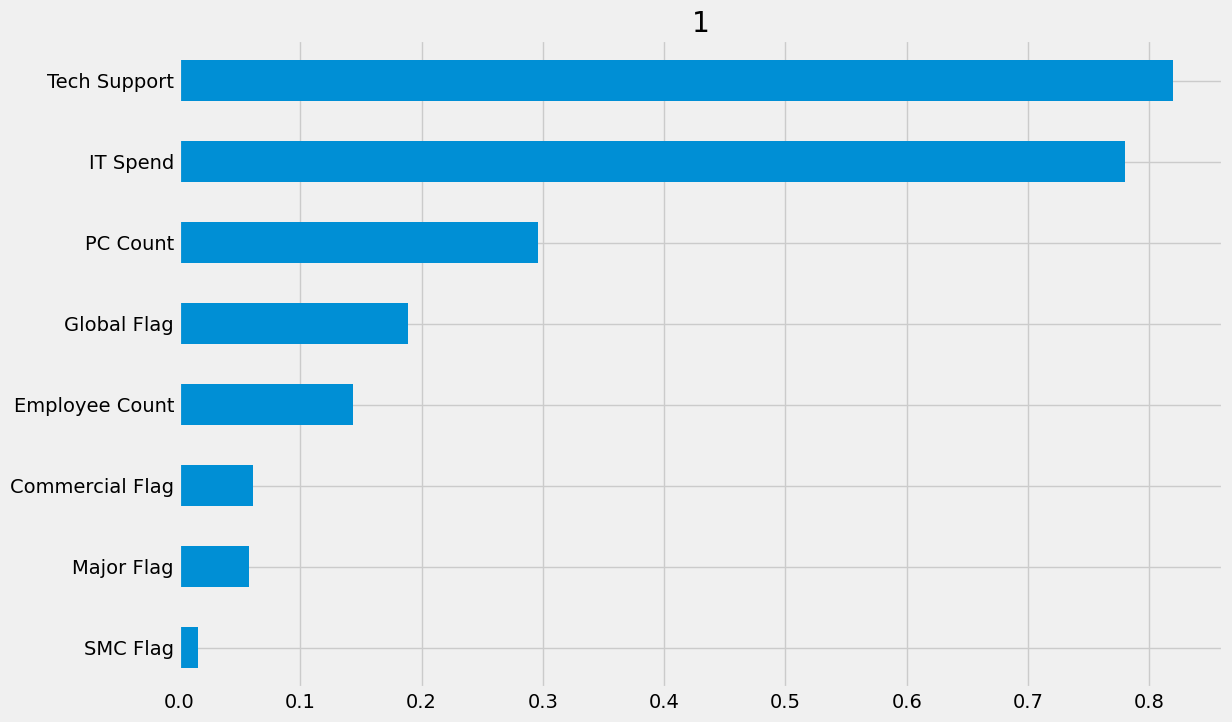

In [530]:
r_learner.plot_importance(X=X,
                         tau=r_ite,
                         method='permutation',
                         features=feature_names,
                         random_state=42)

In [532]:
import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, r_ite, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 8
[LightGBM] [Info] Start training from score -0.060941
Elapsed time: 0.6790037155151367 seconds


In [533]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Tech Support       0.819520
IT Spend           0.780099
PC Count           0.296424
Global Flag        0.189070
Employee Count     0.143891
Commercial Flag    0.060779
Major Flag         0.057715
SMC Flag           0.015940
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

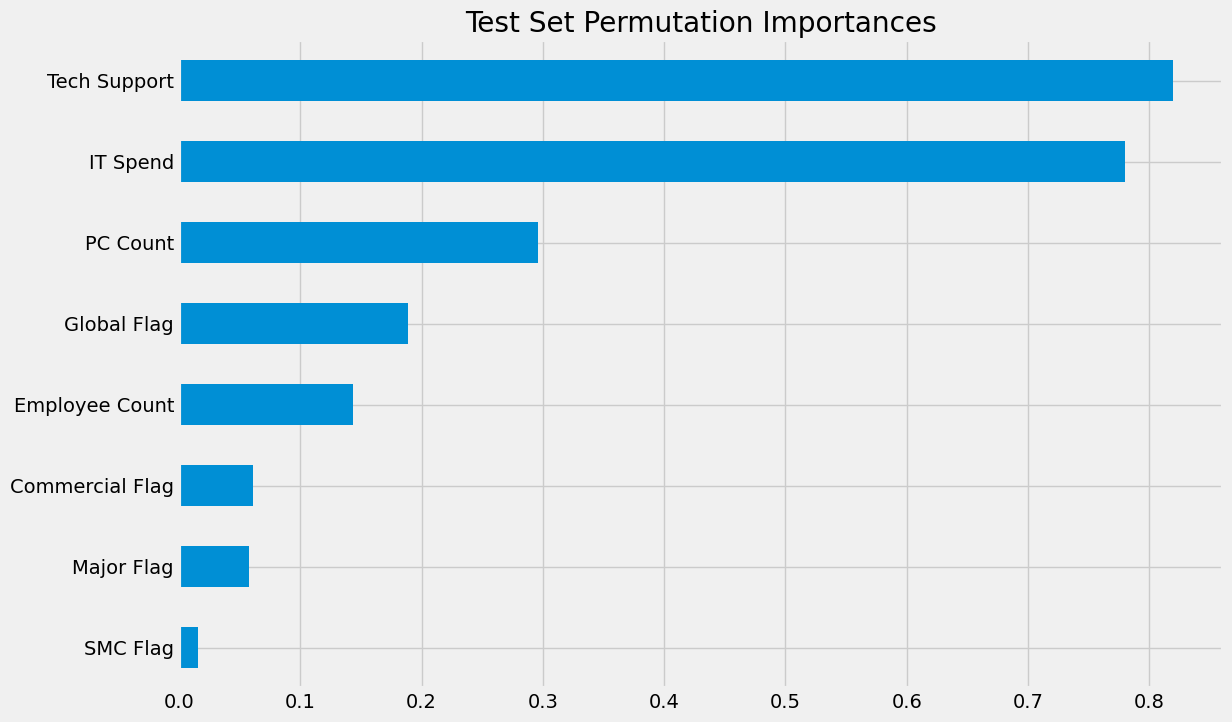

In [534]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [538]:
shap_rlearner = r_learner.get_shap_values(X=X, tau=r_ite)
shap_rlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 0.07560977, -0.00182692,  0.00514403, ...,  0.00098433,
         -0.01065267, -0.03069846],
        [-0.00704616, -0.00402506,  0.00134425, ...,  0.01627978,
          0.015563  , -0.02359028],
        [-0.00724157, -0.00329133, -0.00127752, ..., -0.01007823,
         -0.01819214,  0.06528865],
        ...,
        [-0.00601403,  0.04066917, -0.00932559, ...,  0.02006368,
          0.00991595, -0.02918895],
        [ 0.01610186, -0.00114041, -0.00061668, ...,  0.00291231,
         -0.00446334,  0.01656216],
        [-0.01558905,  0.03596184, -0.00662135, ..., -0.0405905 ,
         -0.04875141, -0.04690789]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

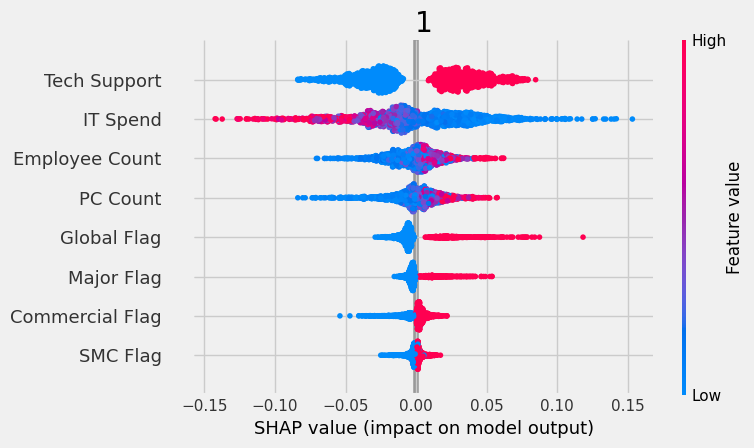

In [539]:
r_learner.plot_shap_values(X=X, tau=r_ite, features=feature_names)

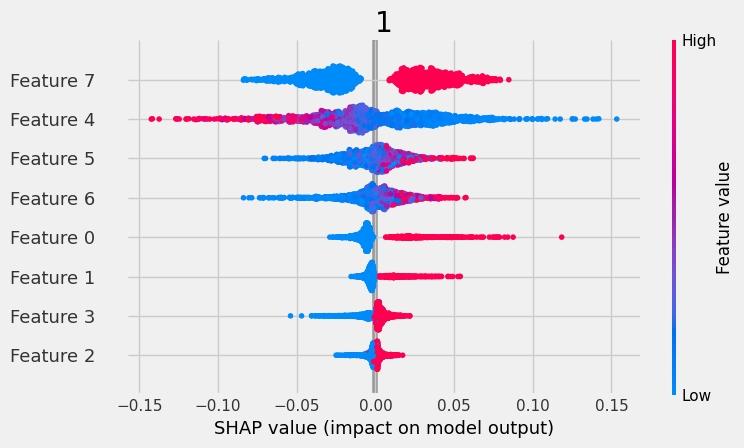

In [540]:
# Plot shap values WITH specifying shap_dict
r_learner.plot_shap_values(X=X, shap_dict=shap_rlearner)

### XGB Testing

In [541]:
s_learner = BaseSRegressor(XGBRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(XGBRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(XGBRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(XGBRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

In [542]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [543]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 10s 32ms/step - loss: 53.7971 - regression_loss: 2.3980 - binary_classification_loss: 44.3420 - treatment_accuracy: 0.5206 - track_epsilon: 0.0111 - val_loss: 48.8904 - val_regression_loss: 0.6278 - val_binary_classification_loss: 39.5214 - val_treatment_accuracy: 0.5201 - val_track_epsilon: 0.0076 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 10ms/step - loss: 49.2510 - regression_loss: 0.4131 - binary_classification_loss: 43.9742 - treatment_accuracy: 0.5381 - track_epsilon: 0.0048 - val_loss: 47.6185 - val_regression_loss: 0.3061 - val_binary_classification_loss: 39.2664 - val_treatment_accuracy: 0.5424 - val_track_epsilon: 0.0024 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 48.7102 - regression_loss: 0.2706 - binary_classification_loss: 43.9532 - treatment_accuracy: 0.5394 - track_epsilon: 0.0017 - val_loss: 47.4846 - val_regression_loss: 0.3645 - val_binary_classificat

In [544]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate],
                     index=['S','T','X','R'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [545]:
df_result

ATE      AUUC
S -0.058288 -0.157873
T -0.060047 -0.101521
X -0.060216 -0.114299
R -0.060421 -0.118045

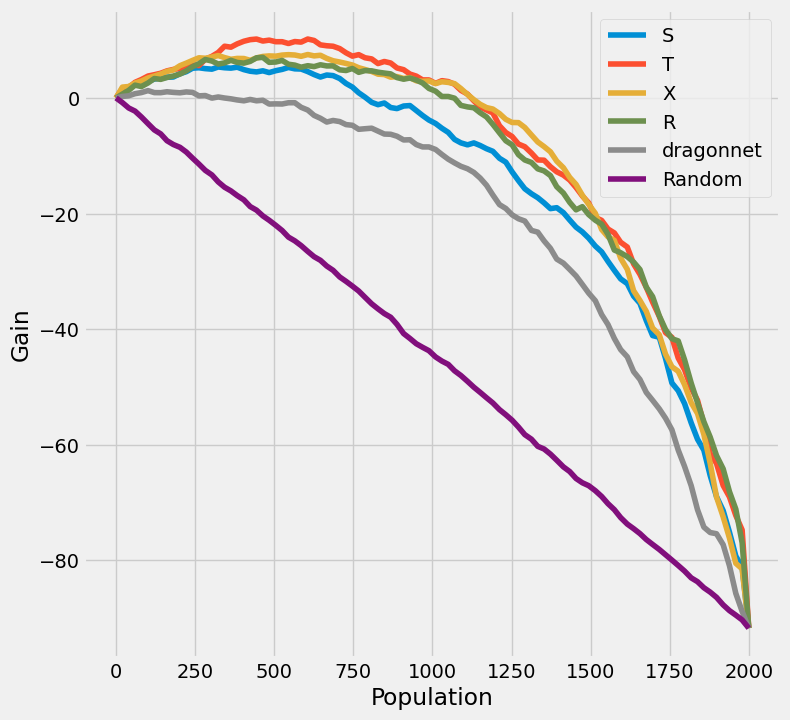

In [546]:
plot_gain(df_preds)

In [547]:
model_tau = XGBRegressor(importance_type='gain')  # specify model for model_tau

In [548]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: IT Spend           0.371191
 Tech Support       0.173868
 PC Count           0.170450
 Employee Count     0.100103
 Global Flag        0.084292
 Commercial Flag    0.047168
 Major Flag         0.038022
 SMC Flag           0.014906
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

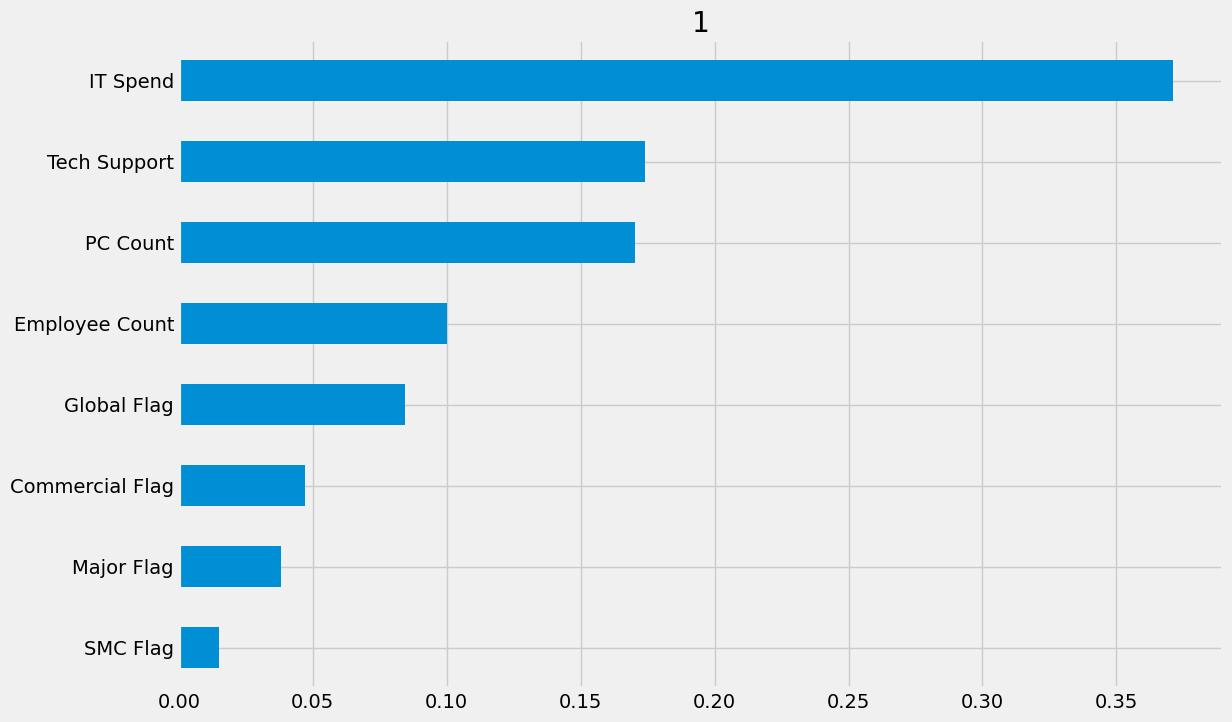

In [549]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names)

In [550]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 5.87126302e-02, -2.19915699e-03,  1.68681650e-04, ...,
          4.80256405e-03, -1.04320220e-02, -3.35572834e-02],
        [-8.48488319e-03, -4.59728217e-03,  1.80023356e-03, ...,
          6.93524887e-03,  3.12401317e-02, -2.76328054e-02],
        [-4.12579143e-03, -3.16030779e-03, -2.44324233e-04, ...,
         -2.05868521e-03, -1.09210307e-02,  5.71240915e-02],
        ...,
        [-6.23742856e-03,  3.41540612e-02, -8.63864865e-05, ...,
          2.09582677e-02, -6.02914080e-05, -2.46076783e-02],
        [ 1.71699813e-02, -1.07891468e-03, -9.90269876e-04, ...,
          2.10966849e-03, -9.09119341e-03,  1.83609211e-02],
        [-1.39610732e-02,  4.76417062e-02, -2.62345377e-03, ...,
         -1.61746978e-02, -2.66582871e-02, -3.37714684e-02]])}

In [551]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, t_ite, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.3603665828704834 seconds


In [552]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 5.87126302e-02, -2.19915699e-03,  1.68681650e-04, ...,
          4.80256405e-03, -1.04320220e-02, -3.35572834e-02],
        [-8.48488319e-03, -4.59728217e-03,  1.80023356e-03, ...,
          6.93524887e-03,  3.12401317e-02, -2.76328054e-02],
        [-4.12579143e-03, -3.16030779e-03, -2.44324233e-04, ...,
         -2.05868521e-03, -1.09210307e-02,  5.71240915e-02],
        ...,
        [-6.23742856e-03,  3.41540612e-02, -8.63864865e-05, ...,
          2.09582677e-02, -6.02914080e-05, -2.46076783e-02],
        [ 1.71699813e-02, -1.07891468e-03, -9.90269876e-04, ...,
          2.10966849e-03, -9.09119341e-03,  1.83609211e-02],
        [-1.39610732e-02,  4.76417062e-02, -2.62345377e-03, ...,
         -1.61746978e-02, -2.66582871e-02, -3.37714684e-02]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

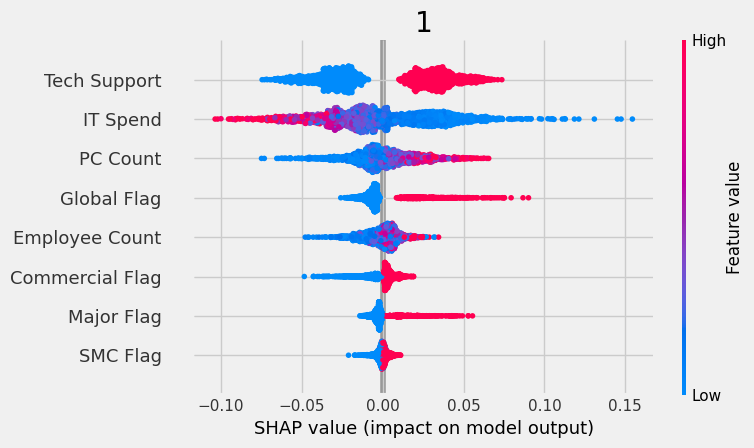

In [553]:
# Plot shap values without specifying shap_dict
t_learner.plot_shap_values(X=X, tau=t_ite, features=feature_names)

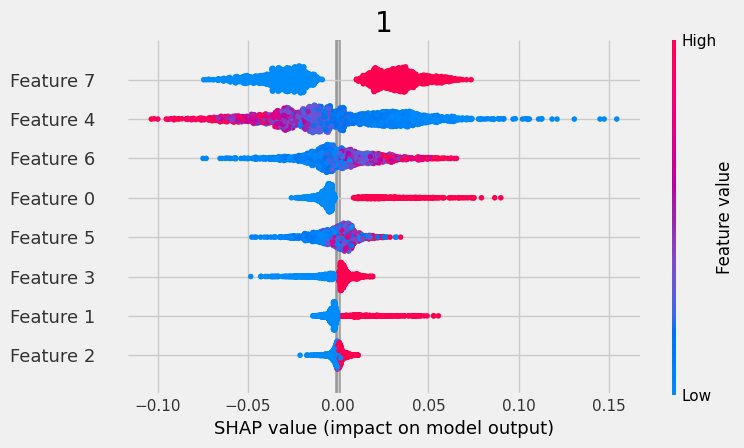

In [554]:
# Plot shap values WITH specifying shap_dict
t_learner.plot_shap_values(X=X, shap_dict=shap_tlearner)

### Conclusion from Discount

- LRS Regression Feature importance

| Feature           | Importance Score |
|-------------------|------------------|
| Tech Support      | 0.819520         |
| IT Spend          | 0.780099         |
| PC Count          | 0.296424         |
| Global Flag       | 0.189070         |
| Employee Count    | 0.143891         |
| Commercial Flag   | 0.060779         |
| Major Flag        | 0.057715         |
| SMC Flag          | 0.015940         |

- XGB Regression Feature importance

| Feature           | Importance Score |
|-------------------|------------------|
| IT Spend          | 0.371191         |
| Tech Support      | 0.173868         |
| PC Count          | 0.170450         |
| Employee Count    | 0.100103         |
| Global Flag       | 0.084292         |
| Commercial Flag   | 0.047168         |
| Major Flag        | 0.038022         |
| SMC Flag          | 0.014906         |



## TECH SUPPORT

### LRS Regression

In [555]:
y = df2.ratio
X = df2.drop(columns=['ratio', 'Tech Support'])
treatment = df2['Tech Support']

print(X.head())

   Global Flag  Major Flag  SMC Flag  Commercial Flag  IT Spend  \
0            1           0         1                0  0.171570   
1            0           0         1                1  0.076092   
2            0           0         0                1  0.313207   
3            0           0         0                0  0.112613   
4            0           0         1                0  0.095764   

   Employee Count  PC Count  Discount  
0        0.030476  0.049875         1  
1        0.184762  0.159601         1  
2        0.000000  0.002494         1  
3        0.057143  0.082294         1  
4        0.051429  0.092269         1  


In [560]:
p_model = ElasticNetPropensityModel()
p = p_model.fit_predict(X, treatment)

In [561]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 9
[LightGBM] [Info] Start training from score 0.441442
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 9
[LightGBM] [Info] Start training from score 0.441442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 522

In [563]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 5s 32ms/step - loss: 53.8094 - regression_loss: 2.4322 - binary_classification_loss: 44.2168 - treatment_accuracy: 0.5269 - track_epsilon: 0.0349 - val_loss: 48.7233 - val_regression_loss: 0.7593 - val_binary_classification_loss: 39.0876 - val_treatment_accuracy: 0.5112 - val_track_epsilon: 0.0253 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 10ms/step - loss: 48.8989 - regression_loss: 0.4659 - binary_classification_loss: 43.5583 - treatment_accuracy: 0.5525 - track_epsilon: 0.0180 - val_loss: 47.0979 - val_regression_loss: 0.4190 - val_binary_classification_loss: 38.7284 - val_treatment_accuracy: 0.5558 - val_track_epsilon: 0.0116 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 10ms/step - loss: 47.4177 - regression_loss: 0.2814 - binary_classification_loss: 42.7075 - treatment_accuracy: 0.5800 - track_epsilon: 0.0081 - val_loss: 46.6125 - val_regression_loss: 0.2912 - val_binary_classificat

In [564]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [565]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, dragon_ate],
                     index=['S','T','X','R','dragonnet'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [567]:
df_result

ATE      AUUC
S         -0.075313 -0.221531
T         -0.076220 -0.190784
X         -0.076017 -0.213757
R         -0.074762 -0.205389
dragonnet -0.076279 -0.268651

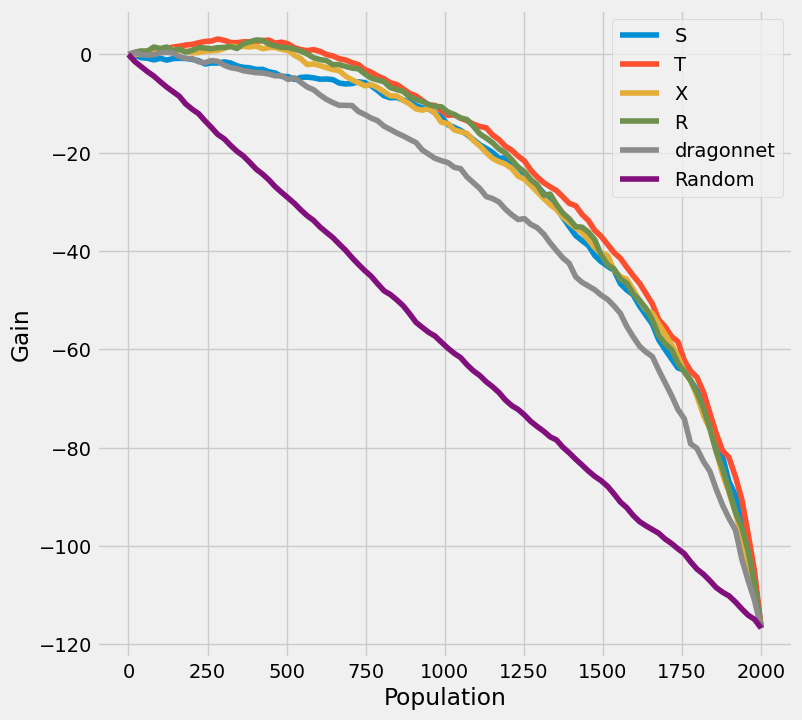

In [568]:
plot_gain(df_preds)

In [578]:
feature_names = []
feature_names = df2.columns
feature_names

Index(['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend',
       'Employee Count', 'PC Count', 'Tech Support', 'Discount', 'ratio'],
      dtype='object')

In [579]:
feature_names = [name for name in feature_names if name not in ['ratio', 'Tech Support']]
model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

In [580]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Discount           0.263832
 PC Count           0.252652
 IT Spend           0.166405
 Global Flag        0.126146
 Commercial Flag    0.068230
 Major Flag         0.061246
 Employee Count     0.050225
 SMC Flag           0.011264
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

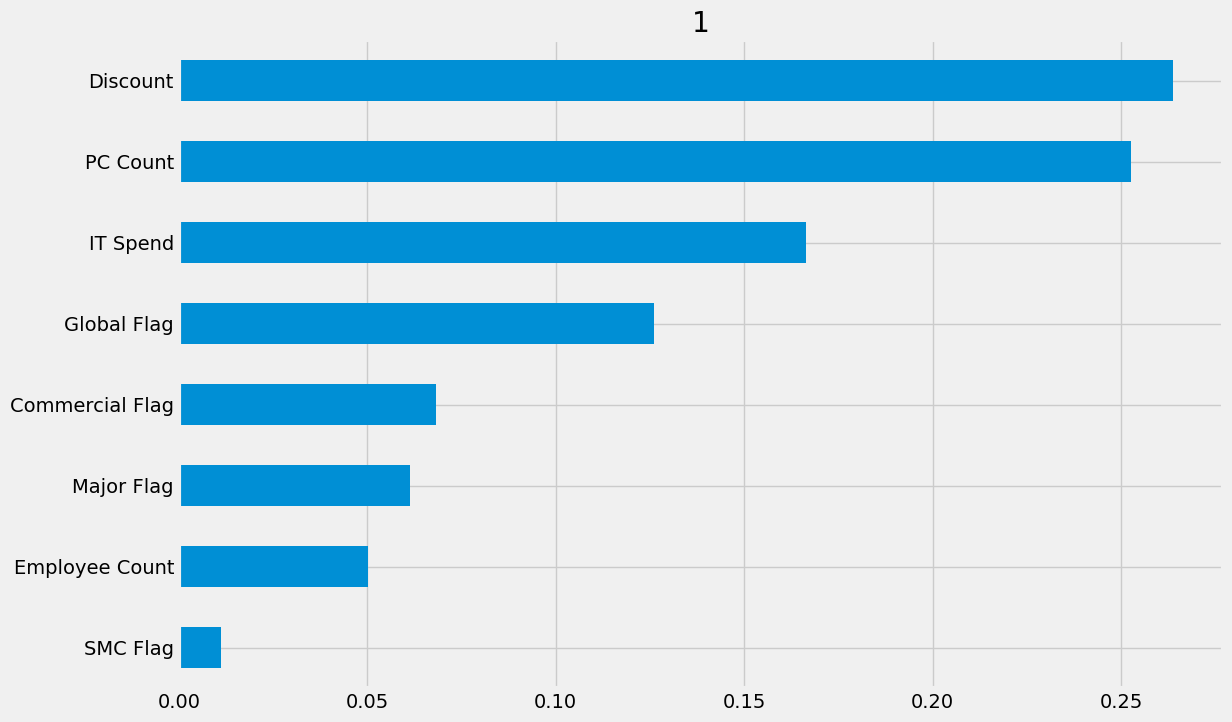

In [581]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names)

In [582]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        method='permutation',
                        features=feature_names,
                        random_state=42)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: Discount           1.054070
 PC Count           0.688253
 IT Spend           0.355067
 Global Flag        0.295815
 Commercial Flag    0.160274
 Major Flag         0.135650
 Employee Count     0.062343
 SMC Flag           0.023837
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

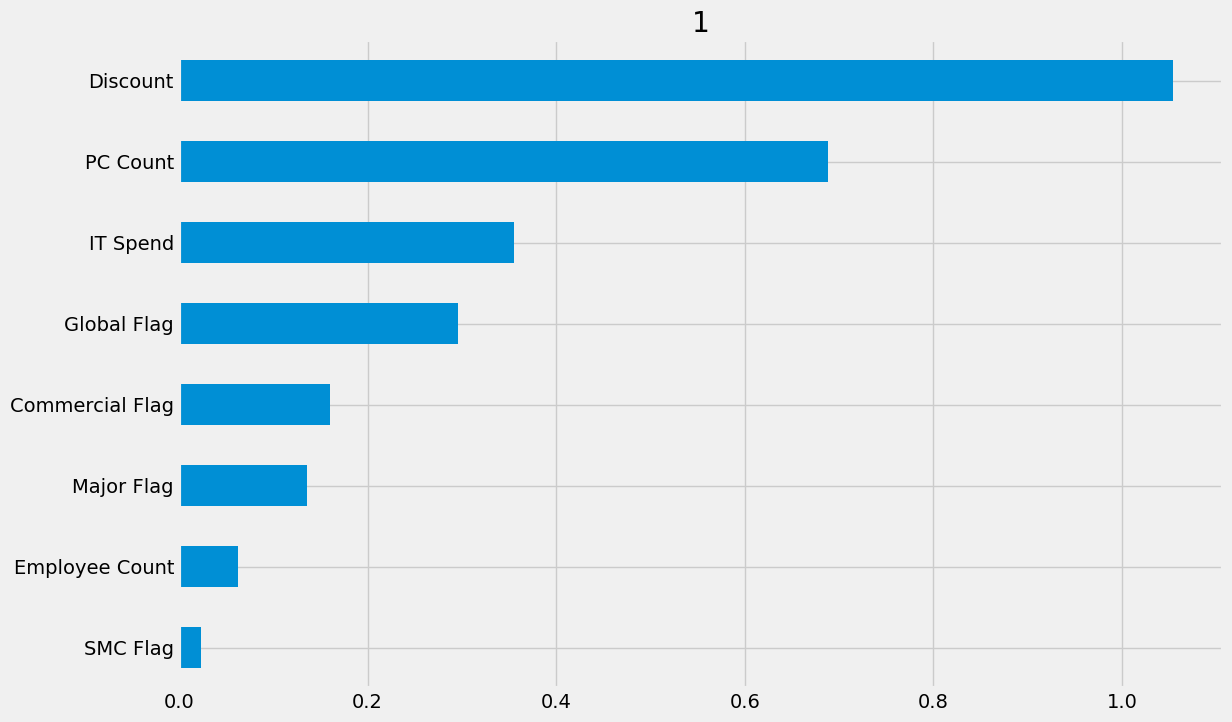

In [583]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         method='permutation',
                         features=feature_names,
                         random_state=42)

In [584]:
import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, t_ite, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 8
[LightGBM] [Info] Start training from score -0.076187
Elapsed time: 0.43938255310058594 seconds


In [585]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

Discount           1.054070
PC Count           0.688253
IT Spend           0.355067
Global Flag        0.295815
Commercial Flag    0.160274
Major Flag         0.135650
Employee Count     0.062343
SMC Flag           0.023837
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

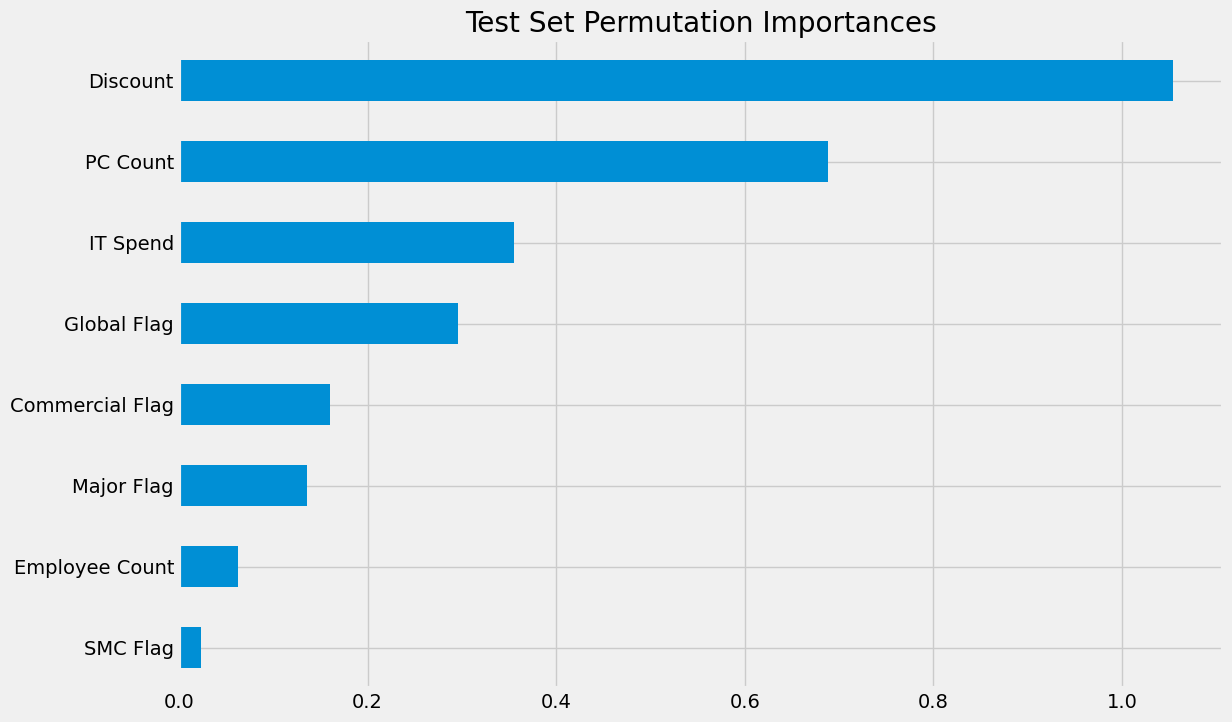

In [586]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [587]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 0.03181077, -0.00266609,  0.0027449 , ...,  0.00556883,
         -0.00701549,  0.03417248],
        [-0.00533651, -0.00418618,  0.00088773, ..., -0.0056713 ,
          0.01578882,  0.02936879],
        [-0.00593633, -0.00712044, -0.00144104, ...,  0.00698489,
         -0.01873052,  0.05309575],
        ...,
        [-0.01487414,  0.04071831, -0.00452758, ...,  0.01256459,
         -0.01921019, -0.03407325],
        [ 0.02658331, -0.00343059, -0.00368313, ..., -0.00330587,
         -0.00304205,  0.02111271],
        [-0.01253821,  0.04737201, -0.00256927, ...,  0.00183246,
         -0.03097285, -0.03447663]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

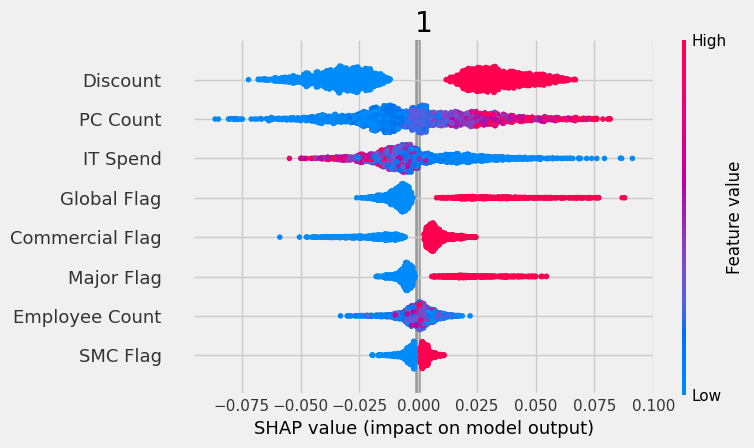

In [588]:
t_learner.plot_shap_values(X=X, tau=t_ite, features=feature_names)

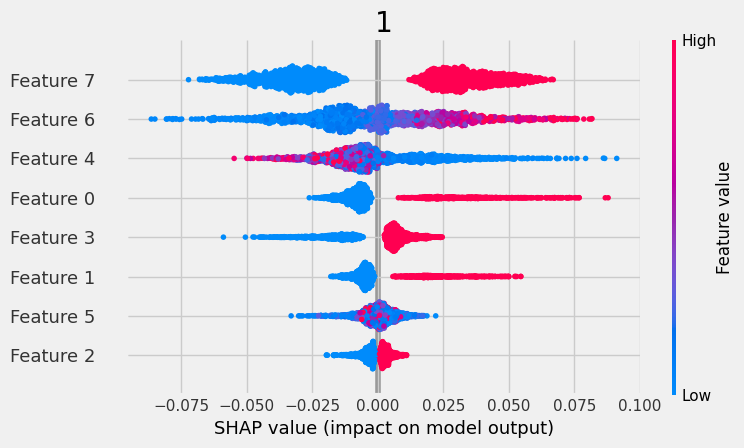

In [589]:
# Plot shap values WITH specifying shap_dict
t_learner.plot_shap_values(X=X, shap_dict=shap_tlearner)

### XGB Testing

In [591]:
s_learner = BaseSRegressor(XGBRegressor())
s_ate = s_learner.estimate_ate(X, treatment, y)[0]
s_ite = s_learner.fit_predict(X, treatment, y)

t_learner = BaseTRegressor(XGBRegressor())
t_ate = t_learner.estimate_ate(X, treatment, y)[0][0]
t_ite = t_learner.fit_predict(X, treatment, y)

x_learner = BaseXRegressor(XGBRegressor())
x_ate = x_learner.estimate_ate(X, treatment, y, p)[0][0]
x_ite = x_learner.fit_predict(X, treatment, y, p)

r_learner = BaseRRegressor(XGBRegressor())
r_ate = r_learner.estimate_ate(X, treatment, y, p)[0][0]
r_ite = r_learner.fit_predict(X, treatment, y, p)

In [592]:
df_preds = pd.DataFrame([s_ite.ravel(),
                          t_ite.ravel(),
                          x_ite.ravel(),
                          r_ite.ravel(),
                          dragon_ite.ravel(),
                          treatment.ravel(),
                          y.ravel()],
                       index=['S','T','X','R','dragonnet','w','y']).T

df_cumgain = get_cumgain(df_preds)

In [593]:
dragon = DragonNet(neurons_per_layer=200, targeted_reg=True)
dragon_ite = dragon.fit_predict(X, treatment, y, return_components=False)
dragon_ate = dragon_ite.mean()

Epoch 1/30
25/25 [==============================] - 4s 30ms/step - loss: 54.9979 - regression_loss: 2.7350 - binary_classification_loss: 44.1470 - treatment_accuracy: 0.5288 - track_epsilon: 0.1170 - val_loss: 49.6237 - val_regression_loss: 1.1115 - val_binary_classification_loss: 39.1619 - val_treatment_accuracy: 0.4955 - val_track_epsilon: 0.1063 - lr: 0.0010
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 49.7658 - regression_loss: 0.9287 - binary_classification_loss: 43.4988 - treatment_accuracy: 0.5569 - track_epsilon: 0.0968 - val_loss: 47.7491 - val_regression_loss: 1.1523 - val_binary_classification_loss: 38.5055 - val_treatment_accuracy: 0.6027 - val_track_epsilon: 0.0867 - lr: 0.0010
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 48.2331 - regression_loss: 0.6570 - binary_classification_loss: 42.8320 - treatment_accuracy: 0.5750 - track_epsilon: 0.0784 - val_loss: 46.5239 - val_regression_loss: 0.4617 - val_binary_classificatio

In [594]:
df_result = pd.DataFrame([s_ate, t_ate, x_ate, r_ate],
                     index=['S','T','X','R'], columns=['ATE'])
df_result['AUUC'] = auuc_score(df_preds)

In [595]:
df_result

ATE      AUUC
S -0.076090 -0.197581
T -0.076772 -0.155867
X -0.077719 -0.193193
R -0.078616 -0.194010

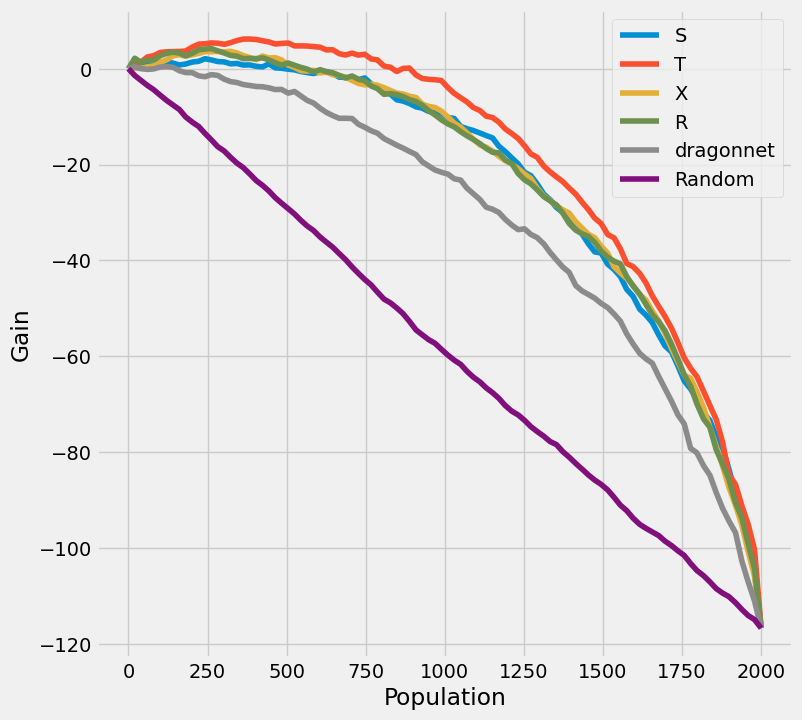

In [596]:
plot_gain(df_preds)

In [597]:
model_tau = XGBRegressor(importance_type='gain')  # specify model for model_tau

In [598]:
t_learner.get_importance(X=X,
                        tau=t_ite,
                        normalize=True,
                        method='auto',
                        features=feature_names)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: PC Count           0.245899
 Discount           0.234424
 IT Spend           0.188839
 Global Flag        0.110232
 Employee Count     0.088994
 Major Flag         0.059858
 Commercial Flag    0.058337
 SMC Flag           0.013416
 dtype: float64}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

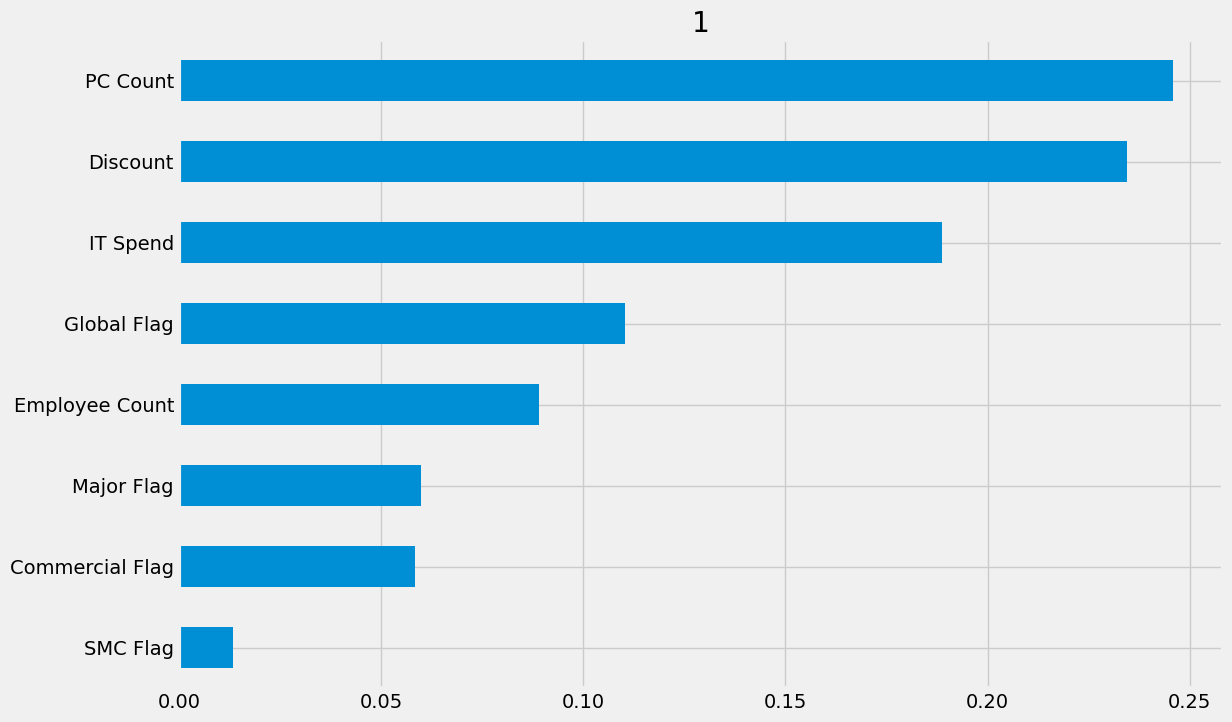

In [599]:
t_learner.plot_importance(X=X,
                         tau=t_ite,
                         normalize=True,
                         method='auto',
                         features=feature_names)

In [600]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 0.03086115, -0.00356445,  0.00245939, ...,  0.00693385,
         -0.00692253,  0.02688631],
        [-0.00538226, -0.00405329,  0.00035406, ..., -0.00687267,
          0.01362785,  0.03171068],
        [-0.0071891 , -0.00730794, -0.00692323, ...,  0.00372524,
         -0.02537936,  0.0560545 ],
        ...,
        [-0.01532637,  0.04198252, -0.00682723, ...,  0.01932059,
         -0.02154159, -0.03244213],
        [ 0.02360187, -0.00400139, -0.00431585, ..., -0.00202801,
         -0.00256413,  0.02204629],
        [-0.01500399,  0.04612045, -0.00351579, ..., -0.00253856,
         -0.03573543, -0.03736431]])}

In [601]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, t_ite, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit,
    X=X_test,
    y=y_test,
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 1.741565227508545 seconds


In [602]:
shap_tlearner = t_learner.get_shap_values(X=X, tau=t_ite)
shap_tlearner

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{1: array([[ 0.03086115, -0.00356445,  0.00245939, ...,  0.00693385,
         -0.00692253,  0.02688631],
        [-0.00538226, -0.00405329,  0.00035406, ..., -0.00687267,
          0.01362785,  0.03171068],
        [-0.0071891 , -0.00730794, -0.00692323, ...,  0.00372524,
         -0.02537936,  0.0560545 ],
        ...,
        [-0.01532637,  0.04198252, -0.00682723, ...,  0.01932059,
         -0.02154159, -0.03244213],
        [ 0.02360187, -0.00400139, -0.00431585, ..., -0.00202801,
         -0.00256413,  0.02204629],
        [-0.01500399,  0.04612045, -0.00351579, ..., -0.00253856,
         -0.03573543, -0.03736431]])}

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

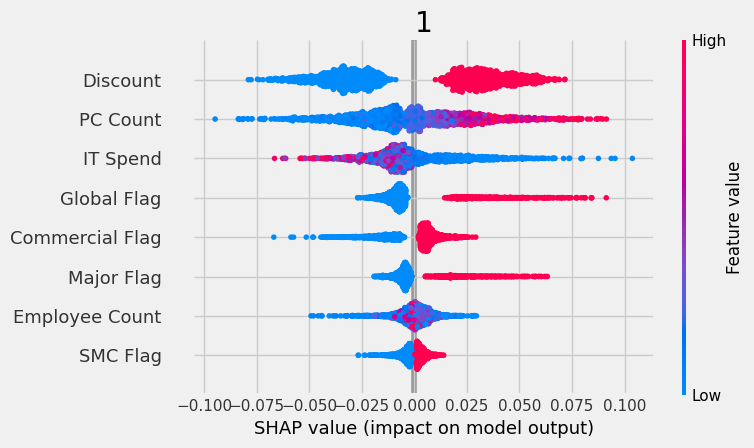

In [603]:
# Plot shap values without specifying shap_dict
t_learner.plot_shap_values(X=X, tau=t_ite, features=feature_names)

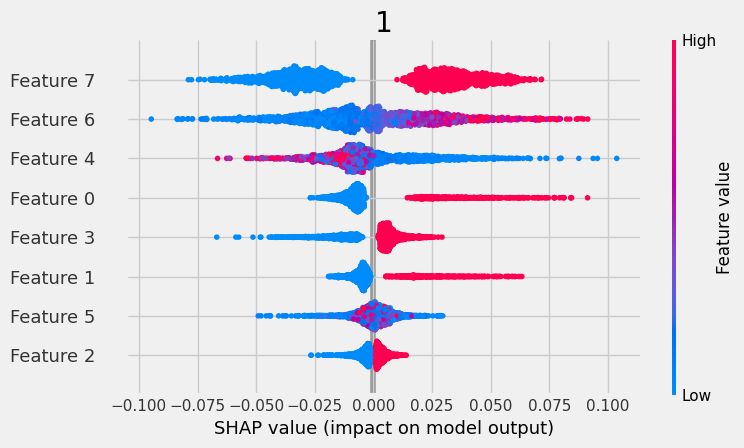

In [604]:
# Plot shap values WITH specifying shap_dict
t_learner.plot_shap_values(X=X, shap_dict=shap_tlearner)

### Conclusion from Tech support

- LRS Regression Feature importance

| Feature           | Importance Score |
|-------------------|------------------|
| Discount          | 1.054070         |
| PC Count          | 0.688253         |
| IT Spend          | 0.355067         |
| Global Flag       | 0.295815         |
| Commercial Flag   | 0.160274         |
| Major Flag        | 0.135650         |
| Employee Count    | 0.062343         |
| SMC Flag          | 0.023837         |


- XGB Regression Feature importance

| Feature           | Importance Score |
|-------------------|------------------|
| PC Count          | 0.245899         |
| Discount          | 0.234424         |
| IT Spend          | 0.188839         |
| Global Flag       | 0.110232         |
| Employee Count    | 0.088994         |
| Major Flag        | 0.059858         |
| Commercial Flag   | 0.058337         |
| SMC Flag          | 0.013416         |



# Conclusion

## Analysis of Feature Importance for Revenue Generation Treatments

The analysis of feature importance from both the Linear Regression with Shrinkage (LRS) and XGBoost (XGB) regression models provides insights into the impact of two different treatments (discount and tech support) on revenue generation for a business.

### Treatment 1: Discount

#### LRS Regression
- **Tech Support** and **IT Spend** are highlighted as the most influential features, suggesting that discounts targeted at customers with existing or potential investments in tech support or IT could significantly boost revenue.
- **PC Count** and **Global Flag** are moderately important, indicating the relevance of the number of PCs and global operations to revenue impact, albeit to a lesser extent.
- Features like **Employee Count**, **Commercial Flag**, **Major Flag**, and **SMC Flag** are less critical, suggesting they have a lesser influence on revenue through discounts.

#### XGB Regression
- **IT Spend** takes precedence, emphasizing the importance of IT investments in affecting revenue, consistent with LRS findings.
- The importance of **Tech Support** and **PC Count** is reinforced, albeit with a slight shift in priority.
- The lower significance of features such as **Employee Count**, **Global Flag**, and various business-related flags is consistent with LRS, indicating they are less impactful.

### Treatment 2: Tech Support

#### LRS Regression
- **Discount** stands out as the most crucial feature, suggesting the effectiveness of tech support is significantly influenced by discount offerings.
- The importance of **PC Count** and **IT Spend** is reiterated, highlighting the role of infrastructure and IT investment level under this treatment.
- Lesser importance of features like **Global Flag**, **Commercial Flag**, **Major Flag**, **Employee Count**, and **SMC Flag** suggests they are less impactful in this context.

#### XGB Regression
- **PC Count** emerges as the primary factor, indicating its significant role in revenue generation when providing tech support.
- The high importance of **Discount** supports LRS findings on the synergy between tech support and discount offerings.
- The significance of **IT Spend**, **Global Flag**, and **Employee Count** follows, consistent with their roles in impacting revenue.

### Conclusions and Insights

1. **Synergy between Discounts and Tech Support**: The analysis suggests a synergistic effect between offering discounts and providing tech support, especially when both are applied together.
2. **Significance of IT Spend**: IT investment is a critical factor across treatments and models, indicating targeting customers with higher IT spend could be more effective.
3. **Role of Infrastructure (PC Count)**: The number of PCs is a key factor, suggesting businesses with more substantial IT infrastructure may derive more benefit from both discounts and tech support.
4. **Lesser Importance of Company Characteristics**: Company size, market segment, and other characteristics are consistently less important, suggesting these factors are less critical in determining treatment effectiveness.

